<a href="https://colab.research.google.com/github/HyberionBrew/skynet_change_prediction/blob/main/net_building_double.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls 

drive  sample_data


In [3]:
!cp drive/MyDrive/Skylab/dataset_middle.zip dataset_middle.zip

In [4]:
%%capture
!unzip dataset_middle.zip

In [5]:
!ls dataset

after  after_label  before  before_label  diff_label  middle  middle_label


In [6]:
#!cp drive/MyDrive/dataset.zip dataset.zip

In [7]:
%%capture
!pip install rasterio
!pip install geopandas
!pip install albumentations==0.4.6

In [8]:
# the precision, dice ... metrics
!git clone https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch.git

Cloning into 'Segmentation-Metrics-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [9]:
!cp Segmentation-Metrics-PyTorch/metric.py metric.py

In [10]:
from metric import BinaryMetrics

In [11]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 530, done.
remote: Total 530 (delta 0), reused 0 (delta 0), pack-reused 530
Receiving objects: 100% (530/530), 47.40 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [12]:
!cp -r Pytorch-UNet/unet/ unet/

In [13]:
import sys
import os
sys.path.append(os.path.abspath("unet/*"))
from unet.unet_parts import *
from unet.unet_model import UNet

In [14]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import imgaug
import random
import albumentations

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

In [15]:
import cv2

In [16]:
total_indx = 2
img1 = cv2.imread('./dataset/before/%06d.png'%total_indx)
img2 = cv2.imread('./dataset/after/%06d.png'%total_indx)
mask1 = torch.load('./dataset/before_label/%06d.pth'%total_indx)
mask2 = torch.load('./dataset/after_label/%06d.pth'%total_indx)
mask_diff = torch.load('./dataset/diff_label/%06d.pth'%total_indx)

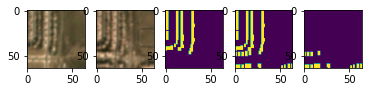

In [17]:
# plt.figure(figsize=(4, 4), dpi=80)
plt.subplot(2, 5, 1)
plt.imshow(img1)

plt.subplot(2, 5, 2)
plt.imshow(img2)

plt.subplot(2, 5, 3)
plt.imshow(mask1)

plt.subplot(2, 5, 4)
plt.imshow(mask2)
plt.subplot(2, 5, 5)
plt.imshow(mask_diff)

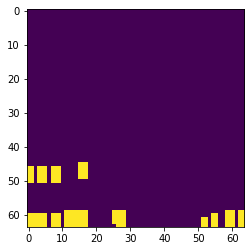

In [18]:
#%%
plt.imshow(mask_diff)

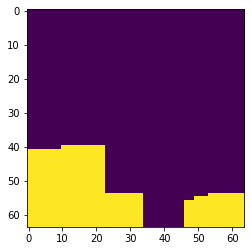

In [19]:
plt.imshow(cv2.GaussianBlur(mask_diff.astype(float),(11, 11), 0) > 0.)

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [21]:
#%%
import glob

In [22]:
paths = glob.glob('./dataset/before/*')
!ls dataset/

after  after_label  before  before_label  diff_label  middle  middle_label


In [23]:
!mkdir dataset/middle_after_diff
!ls dataset

after	     before	   diff_label  middle_after_diff
after_label  before_label  middle      middle_label


In [24]:
# compute diff label from middle to after
path_middle = glob.glob('./dataset/middle_label/*')
path_after = glob.glob('./dataset/after_label/*')
assert(len(path_middle)==len(path_after))
for i in range(len(path_middle)):
    middle_label = torch.load(path_middle[i])
    after_label = torch.load(path_after[i])
    middle_after_diff = np.logical_xor(middle_label,after_label).astype(np.uint8)
    save_path = str(path_middle[i].replace('middle_label','middle_after_diff'))
    torch.save(middle_after_diff,save_path)

print(f"generated: {len(glob.glob('./dataset/middle_after_diff/*'))}")

generated: 5055


In [25]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.paths = glob.glob('./dataset/before/*')
        self.transform = transform
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_before = cv2.imread(self.paths[idx])
        img_middle = cv2.imread(self.paths[idx].replace('before','middle'))
        img_after = cv2.imread(self.paths[idx].replace('before','after'))

        label_diff_before = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        gt_diff_middle = torch.load(self.paths[idx].replace('before','middle_after_diff').replace('png','pth'))
        #label_middle = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        # why do we use label2 here?
        #label1 = torch.load(self.paths[idx].replace('before','before_label').replace('png','pth')) 
        label_interest = cv2.GaussianBlur(gt_diff_middle.astype(float),(11, 11), 0) > 0.
        #label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        if self.transform:
            transformed1 = self.transform(image = img_before,label = label_diff_before)
            transformed2 = self.transform(image = img_middle,label = label_interest)
            transformed3 = self.transform(image = img_after,label = gt_diff_middle)
        img_before = transformed1['image']
        label_diff_before = transformed1['label']
        img_middle = transformed2['image']
        label_interest = transformed2['label']
        img_after = transformed3['image']
        gt_diff_middle = transformed3['label']
        return img_before,img_middle,img_after, label_interest,label_diff_before ,gt_diff_middle


In [26]:
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ]
)

In [27]:
dataset = MyDataset(transform)
img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle = dataset[2000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


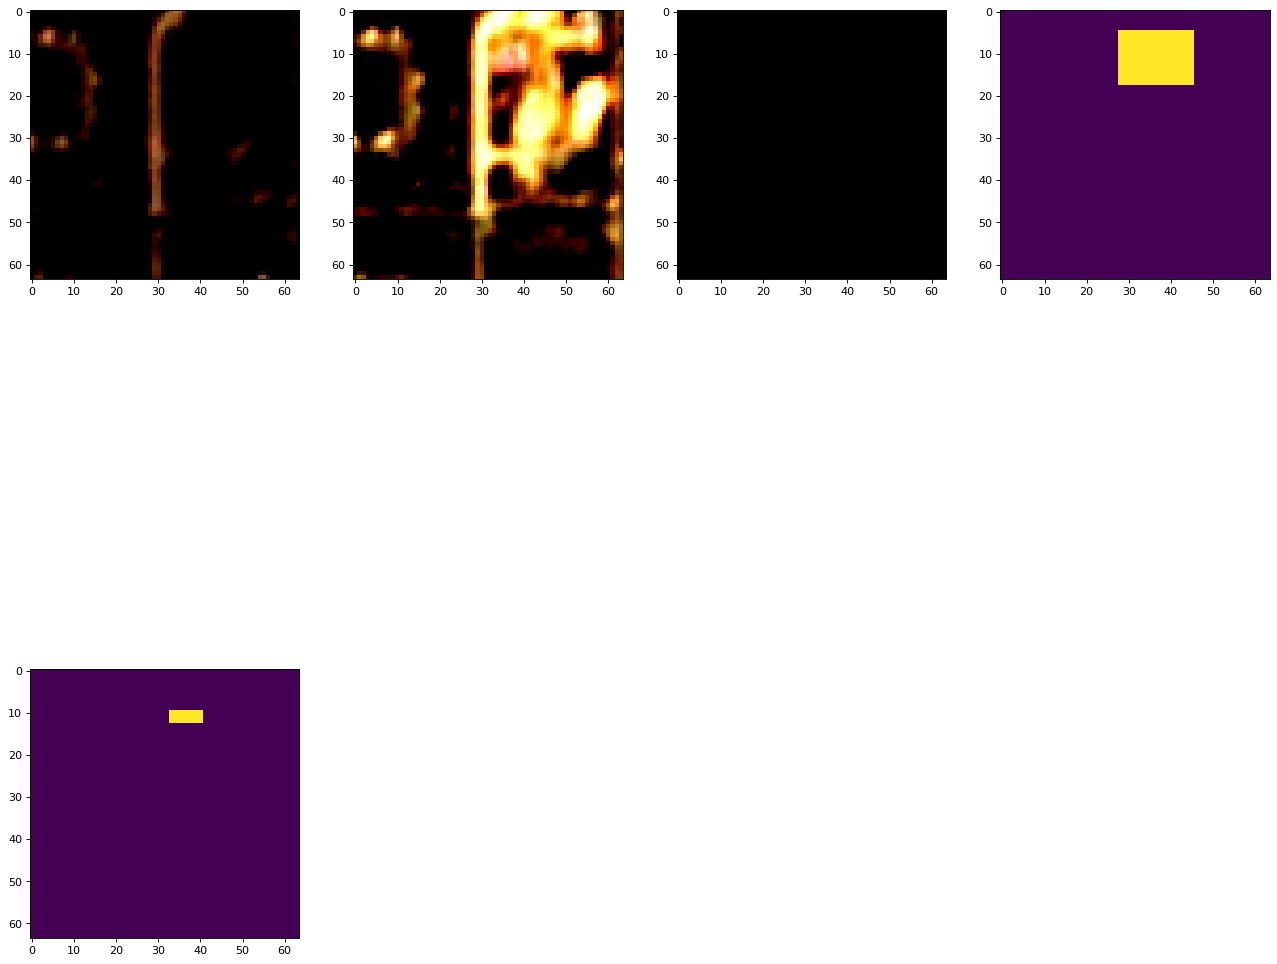

In [28]:
plt.figure(figsize=(20, 20), dpi=80)
plt.subplot(2, 4, 1)
plt.imshow(img_before.permute(1,2,0))

plt.subplot(2, 4, 2)
plt.imshow(img_middle.permute(1,2,0))

plt.subplot(2, 4, 3)
plt.imshow(img_after.permute(1,2,0))

plt.subplot(2, 4, 4)
plt.imshow(label_interest)
plt.subplot(2, 4, 5)
plt.imshow(gt_diff_middle)

In [29]:
from torch.utils.data.sampler import SubsetRandomSampler
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset)- train_size

np.random.seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
val_indices,train_indices = indices[train_size:], indices[:train_size]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

batch_size = 32
num_workers = 3
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=num_workers)

In [30]:
import torch
import numpy as np

import torchvision.transforms.functional as visionF


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = visionF.to_pil_image(img)
        img_gray = np.mean(img, axis=2)
        axs[0, i].imshow(np.asarray(img_gray),cmap=plt.get_cmap('RdYlGn'))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [107]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
def show_batch_images(examples, amount:int, label):
    examples = examples[:amount]
    grid = make_grid(examples)
    show(grid ,label)

In [32]:
#dataloader = DataLoader(dataset, batch_size=8,
#                        shuffle=False, num_workers=3)

In [33]:
def metric(outputs: torch.Tensor, labels: torch.Tensor):
    # y_true: (N, H, W)
    # y_pred: (N, 1, H, W)
    bn = BinaryMetrics()
    metrics = bn(labels,outputs)
    #print(metrics)
    return metrics

In [34]:
!ls 

dataset		    drive      __pycache__   sample_data		   unet
dataset_middle.zip  metric.py  Pytorch-UNet  Segmentation-Metrics-PyTorch


In [35]:
!mkdir utils
!cp -r Pytorch-UNet/utils/ .
!ls utils


data_loading.py  dice_score.py	__init__.py  utils.py


In [36]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        # enable the below to see results with complete input mask
        #label_interest = torch.tensor(np.ones_like(label_interest))
        label_interest = label_interest.cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                           torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output#output[:,-1,:,:]
            #print(f"outmask {out_mask.shape}")
            #out_mask = sig(out_mask.unsqueeze(1))
        #out_image = output[:,:-1,:,:]
       
         # torch.nn.functional.softmax(out_mask, dim=)
        final_mask = out_mask.cpu() #.detach().numpy()
        #print(f"outmask {final_mask.shape}")
        #final_mask = np.zeros_like(det_mask)
        #final_mask[det_mask>0.5] = 1
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [37]:
import torch.nn.functional as F
from utils.dice_score import dice_loss
losses = []
examples = []
metrics_all = []

In [38]:
import torch.nn as nn
from unet.unet_parts import *

class UNet_double_down(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_double_down, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.inc_2 = DoubleConv(n_channels, 64)
        self.down1_2 = Down(64, 128)
        self.down2_2 = Down(128, 256)
        self.down3_2 = Down(256, 512)
        self.down4_2 = Down(512, 1024 // factor)

        self.combine1 = nn.Conv2d(128,64,2,padding="same")
        self.combine2 = nn.Conv2d(256,128,2,padding="same")
        self.combine3 = nn.Conv2d(512,256,2,padding="same")
        self.combine4 =nn.Conv2d(1024,512,2,padding="same")
        self.combine5 =nn.Conv2d(2048,1024 // factor,2,padding="same")
        
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)


    def forward(self, before, between):
        x1 = self.inc(before)
        #64 channels
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x1_2 = self.inc_2(between)
        x2_2 = self.down1_2(x1_2)
        x3_2 = self.down2_2(x2_2)
        x4_2 = self.down3_2(x3_2)
        x5_2 = self.down4_2(x4_2)
        dim = 1
        #print(x1.shape)
        #print(torch.cat((x1,x1_2),dim=dim).shape)
        x1 = self.combine1(torch.cat((x1,x1_2),dim=dim))
        #print(x1.shape)
        x2 = self.combine2(torch.cat((x2,x2_2),dim=dim))
        x3 = self.combine3(torch.cat((x3,x3_2),dim=dim))
        x4 = self.combine4(torch.cat((x4,x4_2),dim=dim))
        x5 = self.combine5(torch.cat((x5,x5_2),dim=dim))

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [39]:
model2 = UNet_double_down(4,1)
model2.eval()
im1 = torch.ones([1,4,64, 64], dtype=torch.float32)
im2 = torch.ones([1,4,64, 64], dtype=torch.float32)
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
output = model2(im1,im2)
print(output.shape)

torch.Size([1, 1, 64, 64])


In [45]:
model = UNet_double_down(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [46]:
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [47]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [48]:

epoch = 50

for e in range(epoch):
    model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        #label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                       torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(output.grad)
        
        losses_epoch.append(float(loss))
        #break
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
        #break
    #break
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses = np.append(losses, losses_epoch)
    model.eval()
    metrics, example, example_label, input_label = test_loop(model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples.append((example,example_label,input_label))
    metrics_all.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.3056506474656383


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9847410446964204; Dice 0.38687954423242243; Precision 0.43295536708573995; Specifity 0.9923767298460007; Recall0.4478382694772887
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2021992367318296


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9849125236272812; Dice 0.40637276414216306; Precision 0.4514771212378383; Specifity 0.9925557766109705; Recall0.454330817433482
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.15537681107915294


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.985341469446818; Dice 0.44152054640303673; Precision 0.4688628769574265; Specifity 0.9923624750226736; Recall0.49677630685459045
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.12074922201201671


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9858282312218632; Dice 0.4740977879307153; Precision 0.4859384584720816; Specifity 0.9922598733433655; Recall0.5380775815477581
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.09542272891115955


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9862551924306899; Dice 0.4944130445329519; Precision 0.506809862011686; Specifity 0.992524626897648; Recall0.5508326290934568
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.07519457313254124


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9867260650628142; Dice 0.512269908973082; Precision 0.5291504308644401; Specifity 0.9929269897854991; Recall0.5590407744931875
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.06033570354613732


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9871216233819723; Dice 0.5312170771853663; Precision 0.5432362980452299; Specifity 0.9930654572322964; Recall0.5775717040572492
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.04840303625999473


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9874758308922703; Dice 0.5482512996929647; Precision 0.555647503860712; Specifity 0.9931960236281157; Recall0.5952665511224241
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.039493837166489576


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9877750507245461; Dice 0.5610292802230796; Precision 0.5701233098330697; Specifity 0.9934306152475377; Recall0.6027464910140409
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03343984924667463


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9880885971853366; Dice 0.5739471697441689; Precision 0.582306030511636; Specifity 0.9936131294816732; Recall0.6132506898713362
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.027865963819341397


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9883907145953604; Dice 0.5847990906644106; Precision 0.5944818585087231; Specifity 0.9938294691964984; Recall0.6201379724945999
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.024004921955093156


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.988668808961908; Dice 0.5947498015419667; Precision 0.6079472166337649; Specifity 0.9940508256355921; Recall0.6249875610105811
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.020796232959475573


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9889228868996724; Dice 0.6048645660612755; Precision 0.6176866407774464; Specifity 0.9941864983411506; Recall0.6332768425375799
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018768988073048158


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9891374701743617; Dice 0.6143973439586534; Precision 0.6235360650159928; Specifity 0.9942249765290934; Recall0.6450821358519984
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.017331664989460406


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.989365174021158; Dice 0.6228359871942156; Precision 0.6335530851378276; Specifity 0.99439071253356; Recall0.6502018464342272
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.015542632240186057


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.989561061717962; Dice 0.6308876699998209; Precision 0.6409293592692269; Specifity 0.9944827297800466; Recall0.657505792421151
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01462368358395935


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9897409387864172; Dice 0.6370629106168467; Precision 0.6506953474255711; Specifity 0.99465461820364; Recall0.6595506209438755
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013978995404785543


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9899235458246299; Dice 0.6434414445719566; Precision 0.6582252057828422; Specifity 0.9947742308889117; Recall0.6636064780367001
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013318771553247816


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990069464018399; Dice 0.6495607279820892; Precision 0.6626433586727544; Specifity 0.9948209392922845; Recall0.670319522013557
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01282457760755178


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902098887478528; Dice 0.6547895214386624; Precision 0.6670074320058512; Specifity 0.9948863268870375; Recall0.6752754769349628
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012322405776683622


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9903301167457054; Dice 0.659608630889159; Precision 0.6724293025234144; Specifity 0.9949640900207063; Recall0.6787793932425242
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012068212151483406


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904406045377254; Dice 0.6640442178014532; Precision 0.6769370373063136; Specifity 0.9950310950726271; Recall0.6822133303825627
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012015749647201398


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9905499745733463; Dice 0.6683385305167404; Precision 0.6812972033561469; Specifity 0.9950987062631891; Recall0.6856945954066984
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011523772432564163


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9906520057745554; Dice 0.6728439464533784; Precision 0.6851737304439192; Specifity 0.995147690107977; Recall0.6899625754553752
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011487361733017004


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990749288749482; Dice 0.6763946193459855; Precision 0.6891724331989927; Specifity 0.9952114960843963; Recall0.6924712589094478
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011153388768434525


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908497731105007; Dice 0.6802487704443533; Precision 0.6928532696894572; Specifity 0.9952599986873824; Recall0.6958349745030865
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01068235025007835


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909380502377947; Dice 0.6834174725217632; Precision 0.6967413237088959; Specifity 0.9953243677814801; Recall0.6975909254529883
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010645624318006119


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910108552825067; Dice 0.6861206486271285; Precision 0.7004266414088627; Specifity 0.9953892715876141; Recall0.6987873161707971
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010263657191856287


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910906211589463; Dice 0.6888807462228473; Precision 0.703184664286118; Specifity 0.9954374592634849; Recall0.7009063953607165
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009960788965782546


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911606288656141; Dice 0.6920725391943358; Precision 0.7057478124575218; Specifity 0.9954678476646994; Recall0.7041644144422907
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009645330739816226


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912282364881214; Dice 0.6948908551259086; Precision 0.7081004745836679; Specifity 0.9955009126707035; Recall0.7067998162046784
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009447867490761862


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912931116031749; Dice 0.697473044932145; Precision 0.7103519566160474; Specifity 0.9955302037298679; Recall0.709234404006499
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009385962823889857


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913409916787512; Dice 0.6995463321857165; Precision 0.7113484265091552; Specifity 0.9955378914665844; Recall0.7120269381506418
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008824111187031244


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913960371065784; Dice 0.7018058494078157; Precision 0.7123395833126629; Specifity 0.9955456011198662; Recall0.7151268801941911
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008654017756715066


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914364163812838; Dice 0.7039822749541004; Precision 0.7132566328420482; Specifity 0.9955423834096444; Recall0.7182634842202702
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008149683616659421


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914899953187276; Dice 0.7061437214359269; Precision 0.7146428256859413; Specifity 0.9955607774452522; Recall0.7207941192525174
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008076990558582497


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9915417740121484; Dice 0.7080058470128485; Precision 0.716466693283546; Specifity 0.9955933349672705; Recall0.7223264245095706
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007827173918485641


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9915886072033062; Dice 0.7099689598438226; Precision 0.7179931899046782; Specifity 0.9956133875359849; Recall0.7243688935425812
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007287995717451563


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916279859663475; Dice 0.7117376343251702; Precision 0.7190568259797664; Specifity 0.9956237055982152; Recall0.7264441573959596
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007294308618774388


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916724099149538; Dice 0.7134775596252716; Precision 0.7205933732102111; Specifity 0.9956446168294479; Recall0.7279540422752021
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006685411556638542


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9917050508612936; Dice 0.714417264605653; Precision 0.7222828271388357; Specifity 0.9956792070191692; Recall0.7278534801560916
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0066363208745716246


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991739452092184; Dice 0.7159492706459768; Precision 0.7236286553504758; Specifity 0.9956950621886386; Recall0.7292010933378543
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006510553984191474


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9917726511054713; Dice 0.7173325739511336; Precision 0.7246101149815606; Specifity 0.995705907314044; Recall0.7306618184145254
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0059808982805693595


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9918072266068231; Dice 0.7188101126509151; Precision 0.7254991096080008; Specifity 0.9957166546361244; Recall0.7324109794186029
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0059985057927492095


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9918360848290225; Dice 0.7199034797759113; Precision 0.7264510842362443; Specifity 0.9957325767027214; Recall0.7333398681959018
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005451573007630082


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9918670984251159; Dice 0.7210394420598241; Precision 0.7277233459067004; Specifity 0.9957539606839418; Recall0.734008058241363
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005264761543275392


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9918867419660091; Dice 0.7220027438359267; Precision 0.7285981376331472; Specifity 0.995767190977931; Recall0.7347449968206172
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005019392998335428


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9919116819167838; Dice 0.7231161451399917; Precision 0.7295112553848963; Specifity 0.9957772892552847; Recall0.7357678580125645
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004723832882962769


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9919375101319299; Dice 0.7240486992696736; Precision 0.7302382772369476; Specifity 0.9957902151374862; Recall0.7366265673378802
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00468003938678564


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9919537174040979; Dice 0.725076334814025; Precision 0.7303667350208444; Specifity 0.9957789009401821; Recall0.7383960881718942
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


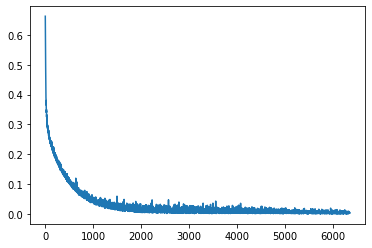

In [63]:
plt.plot(losses[381:])

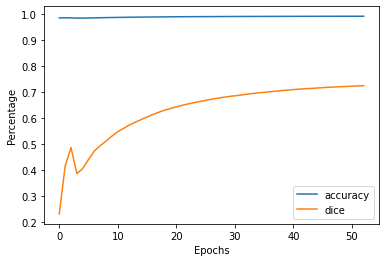

In [64]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy")
plt.plot([metr[1] for metr in metrics_all], label= "dice")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()

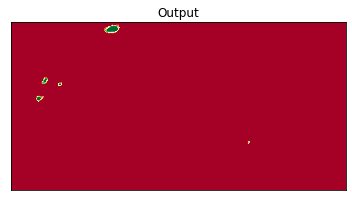

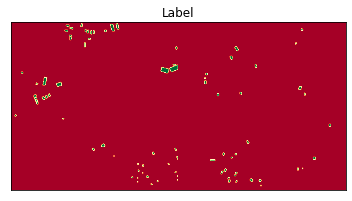

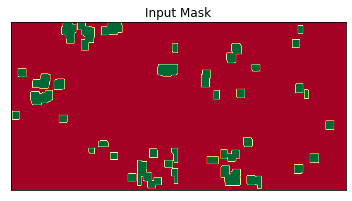

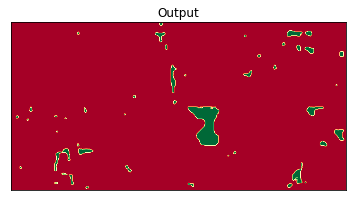

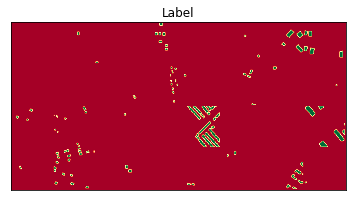

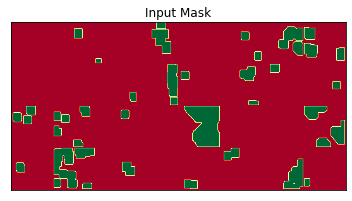

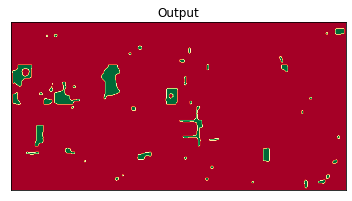

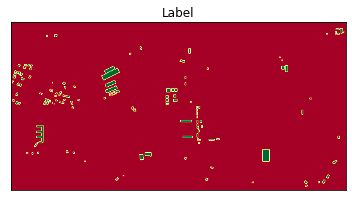

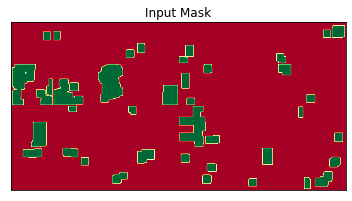

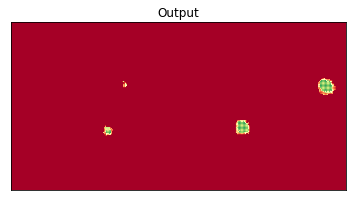

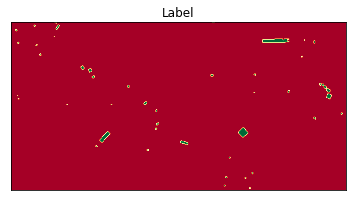

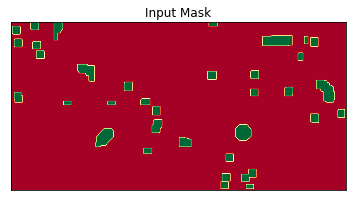

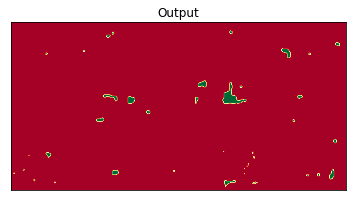

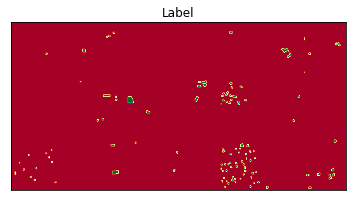

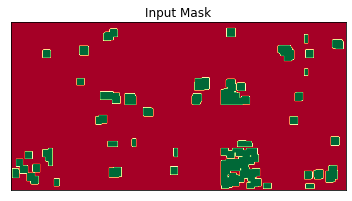

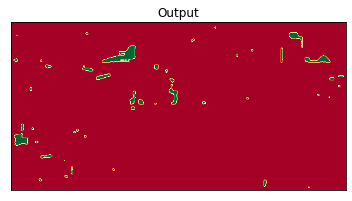

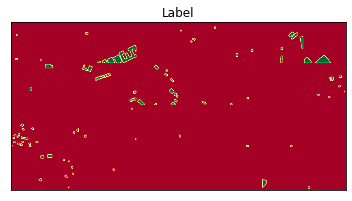

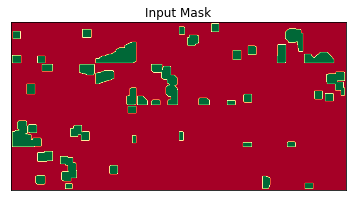

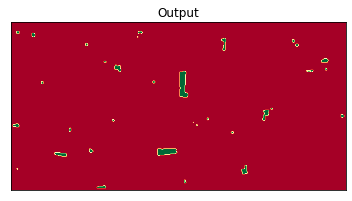

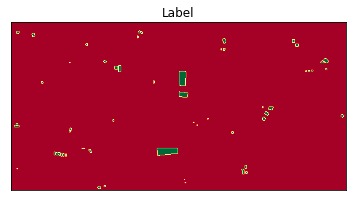

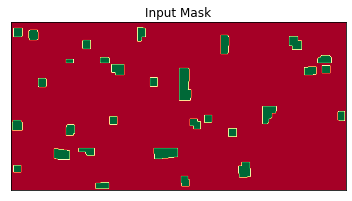

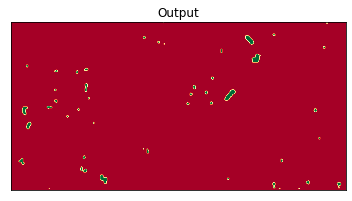

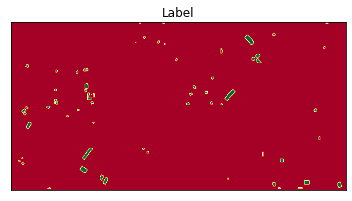

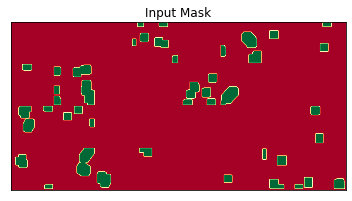

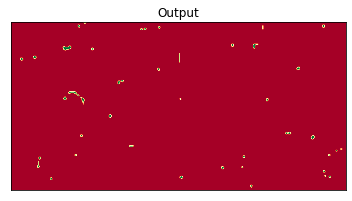

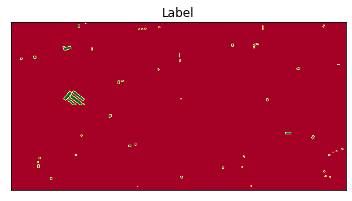

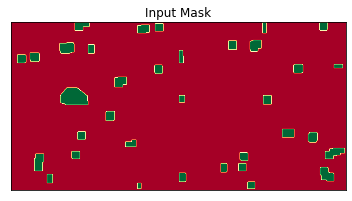

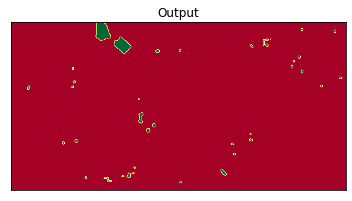

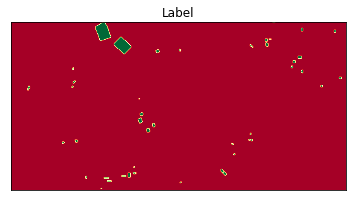

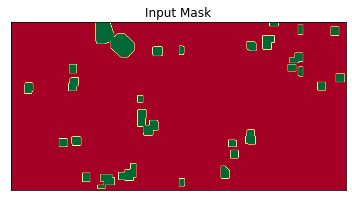

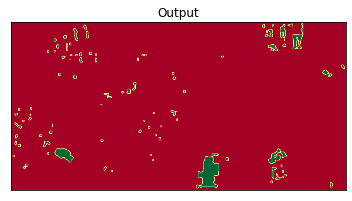

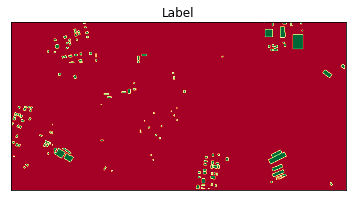

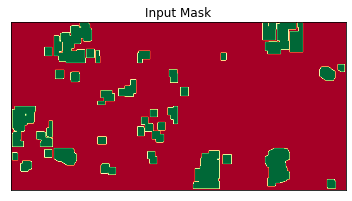

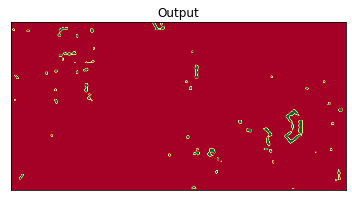

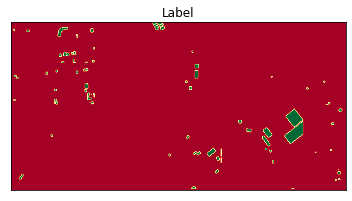

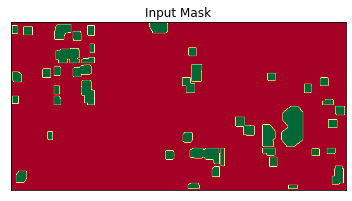

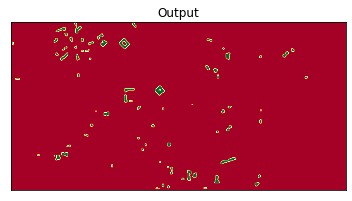

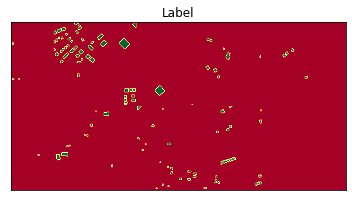

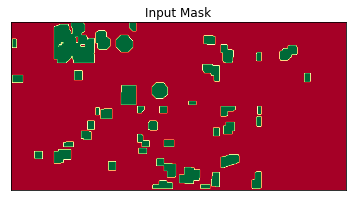

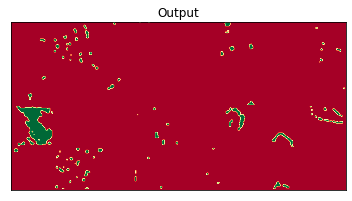

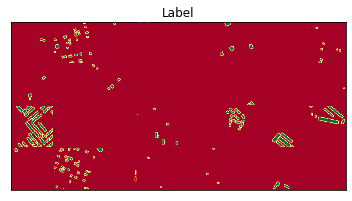

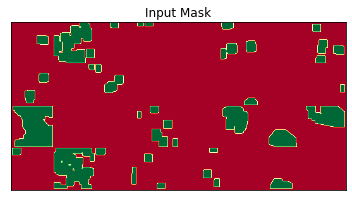

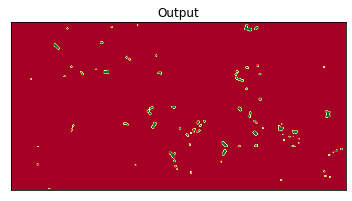

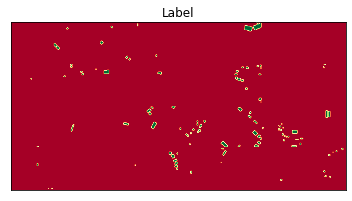

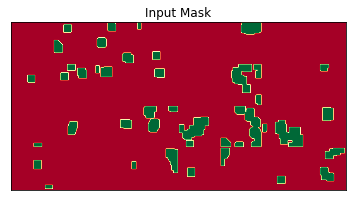

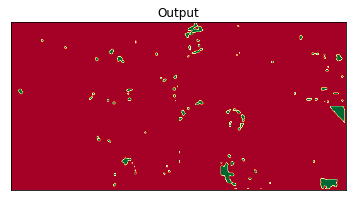

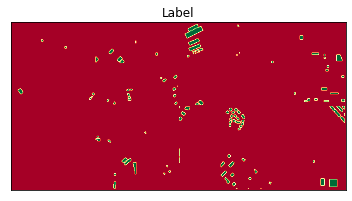

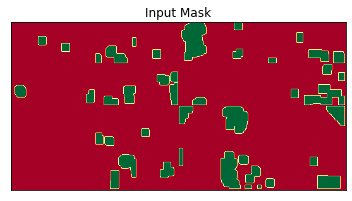

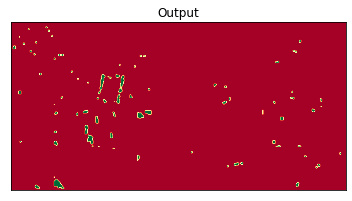

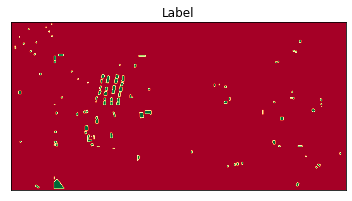

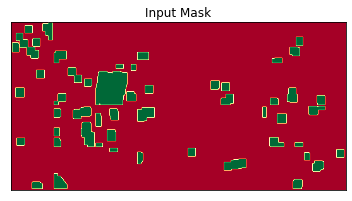

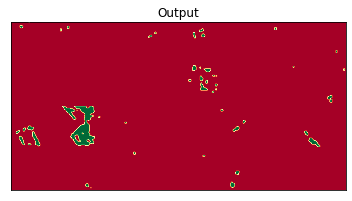

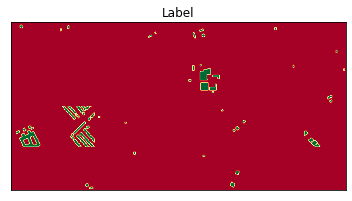

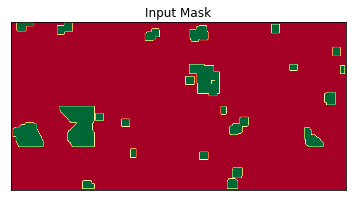

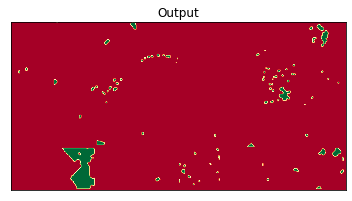

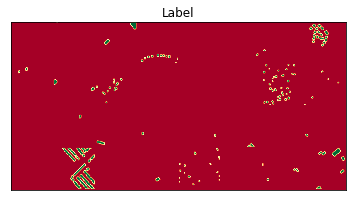

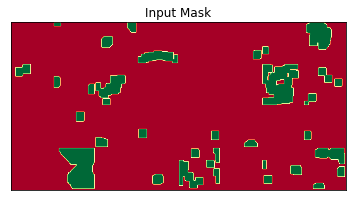

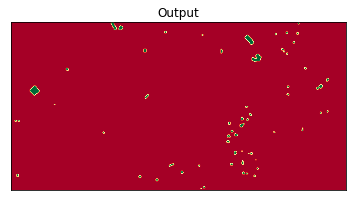

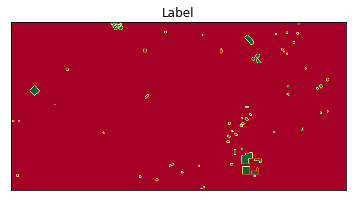

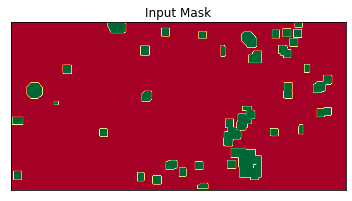

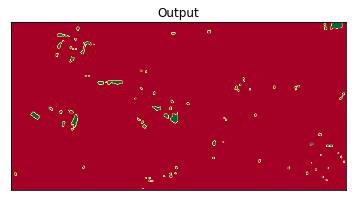

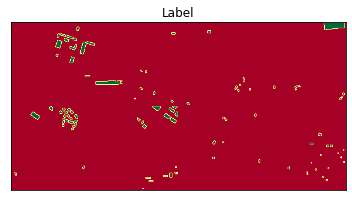

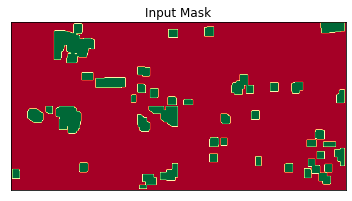

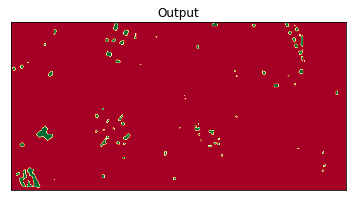

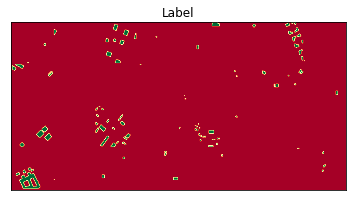

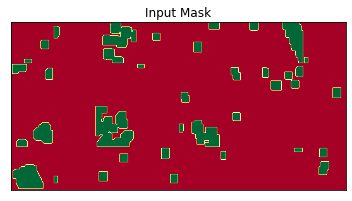

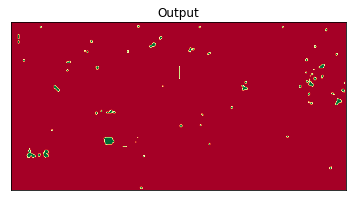

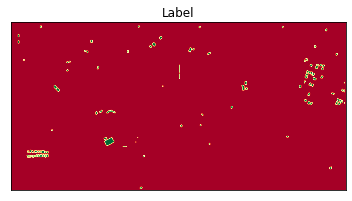

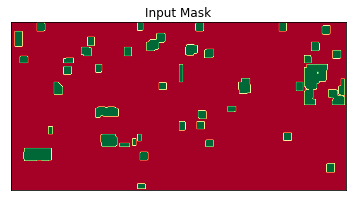

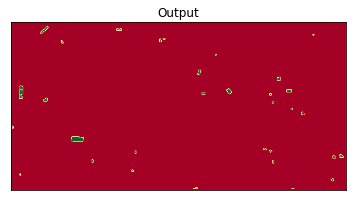

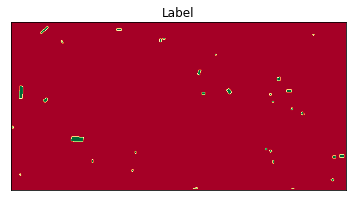

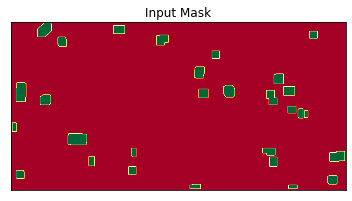

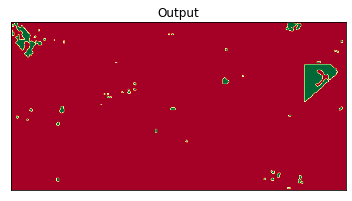

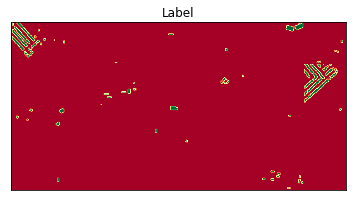

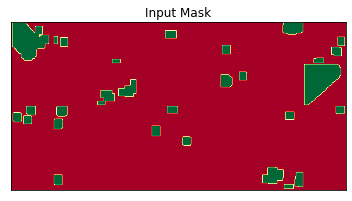

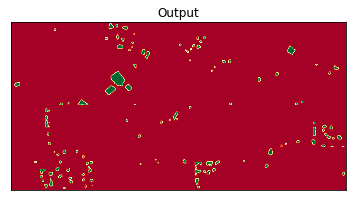

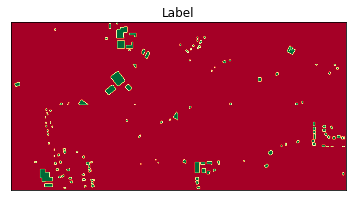

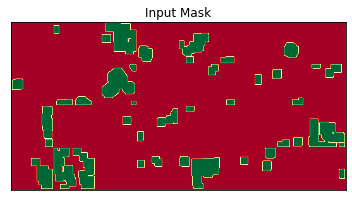

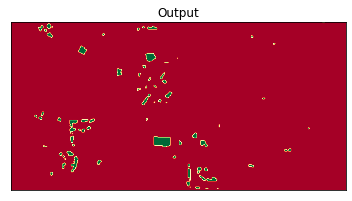

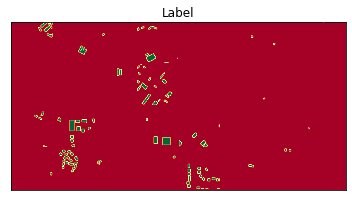

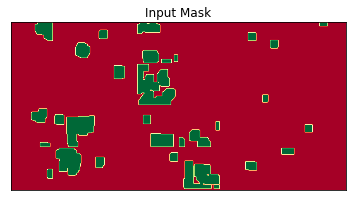

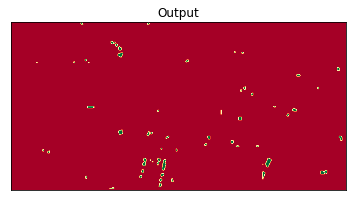

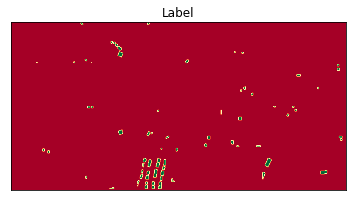

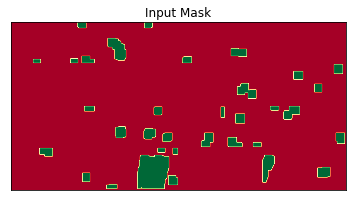

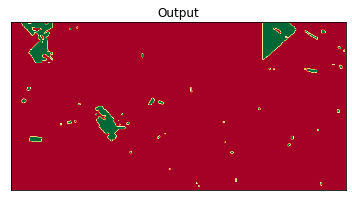

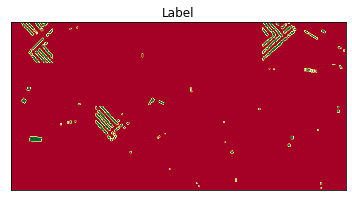

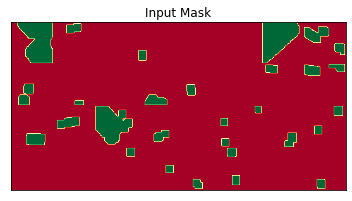

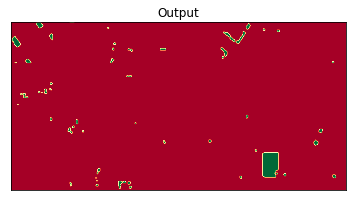

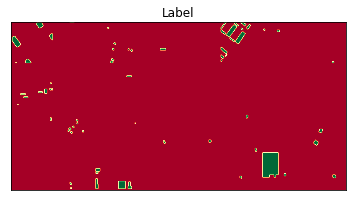

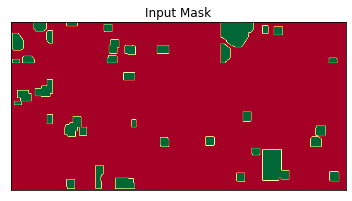

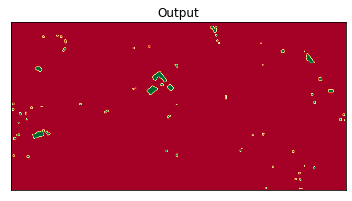

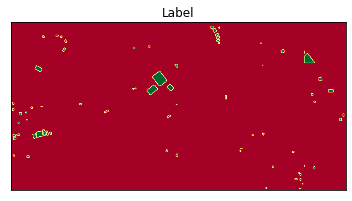

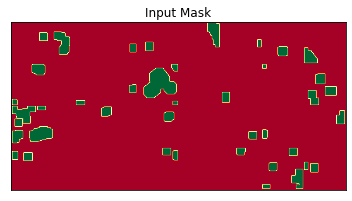

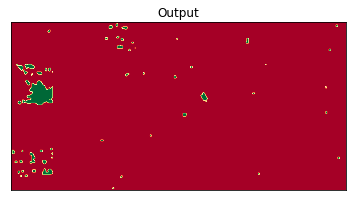

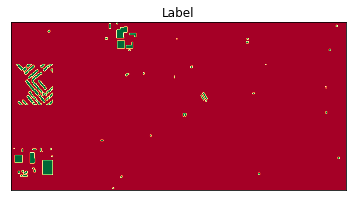

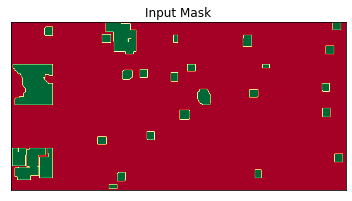

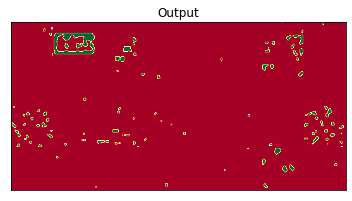

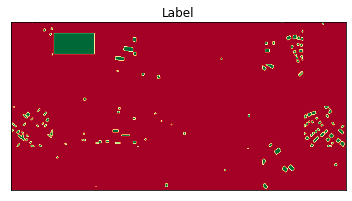

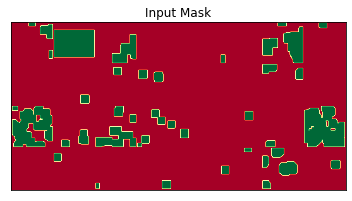

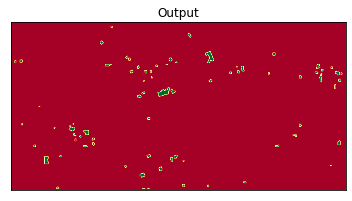

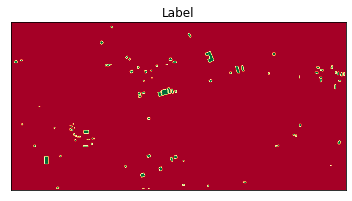

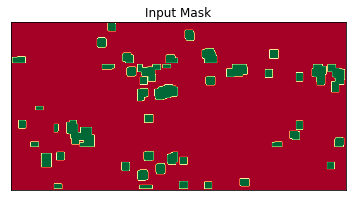

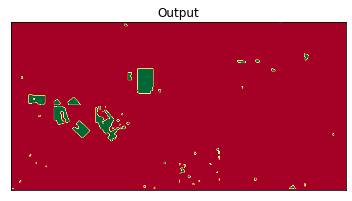

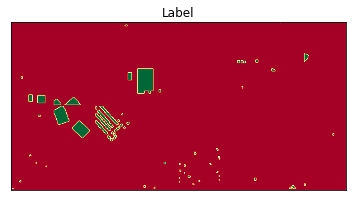

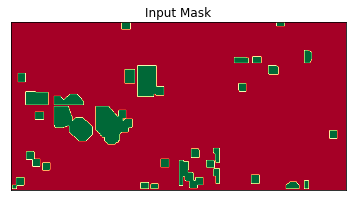

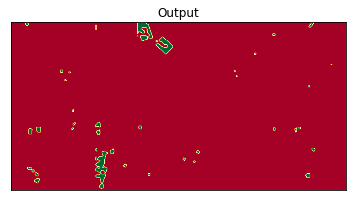

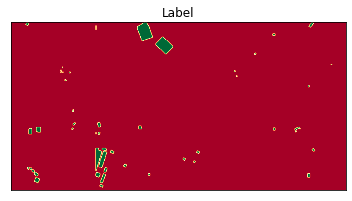

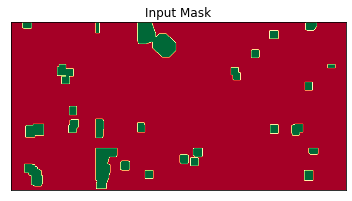

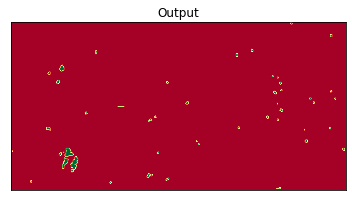

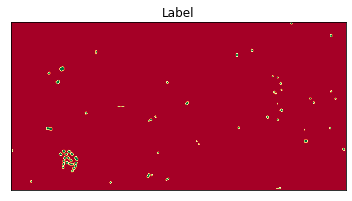

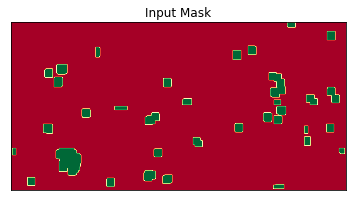

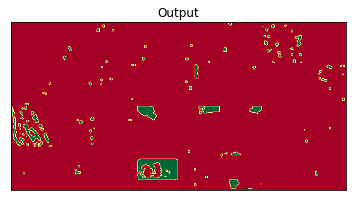

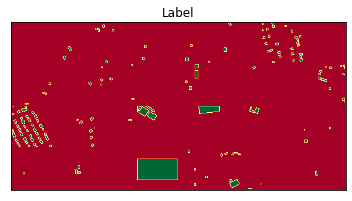

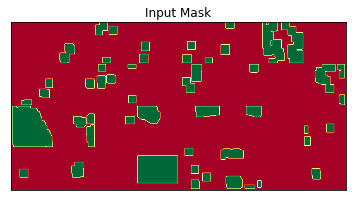

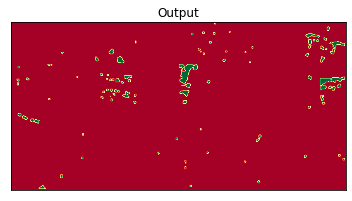

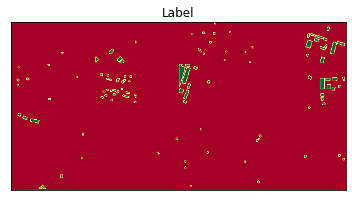

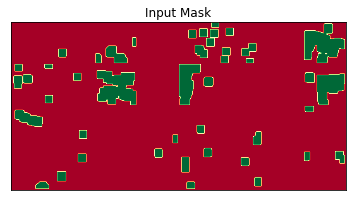

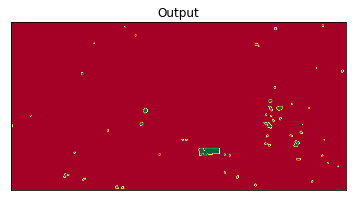

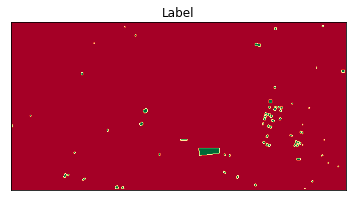

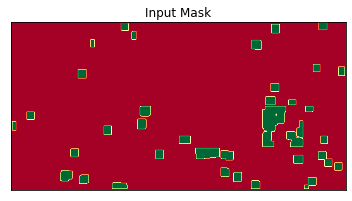

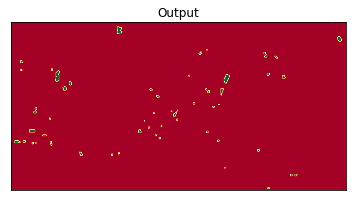

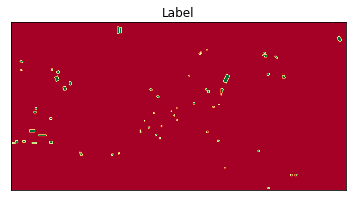

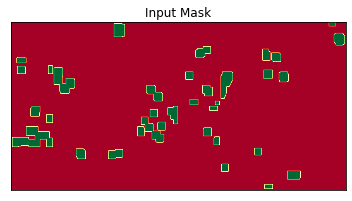

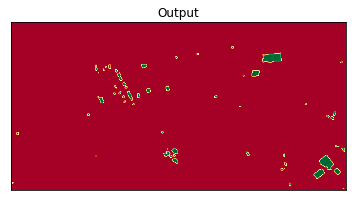

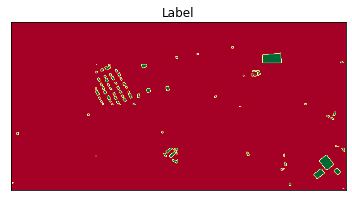

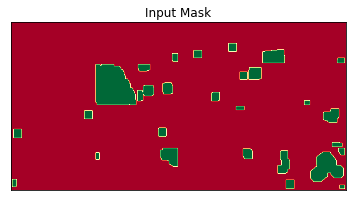

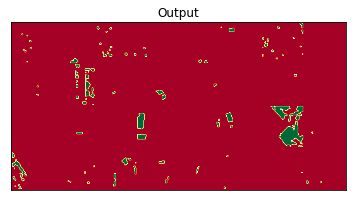

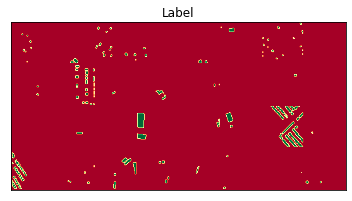

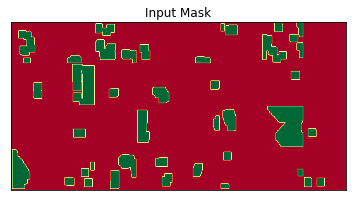

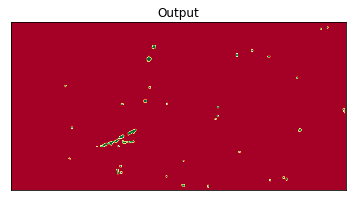

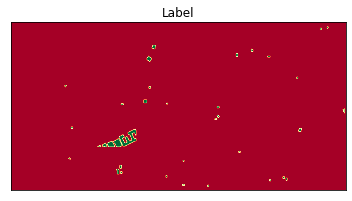

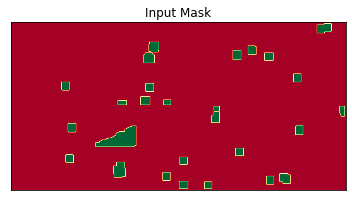

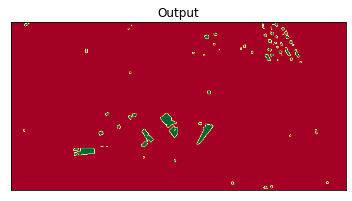

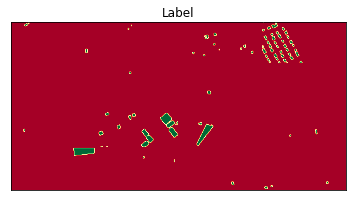

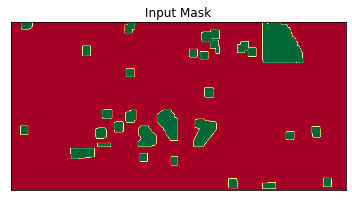

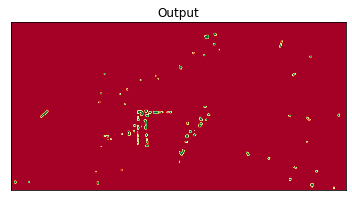

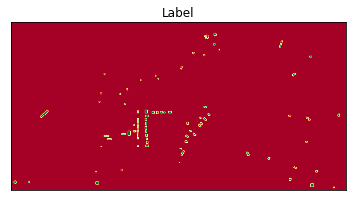

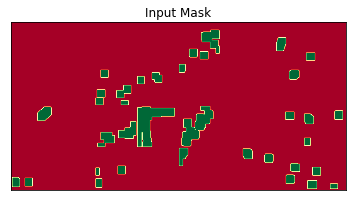

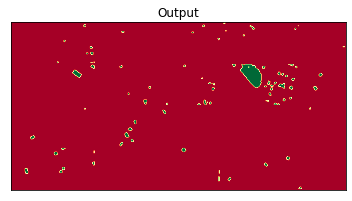

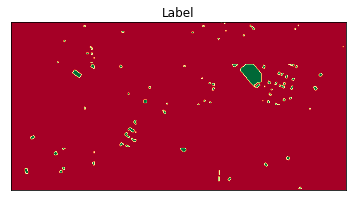

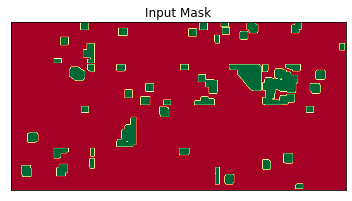

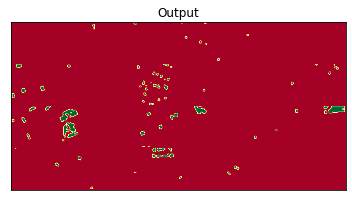

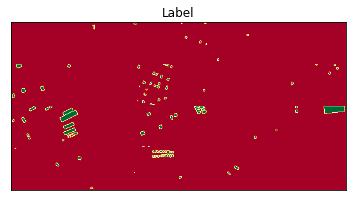

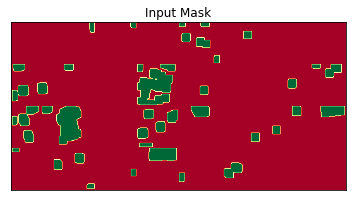

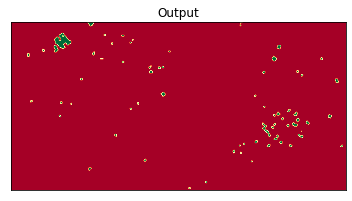

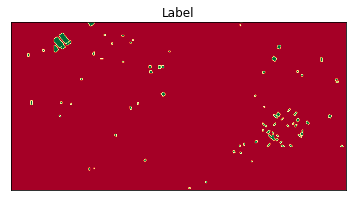

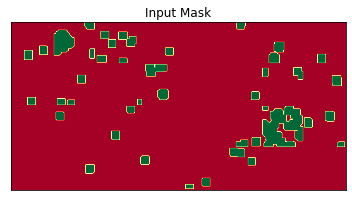

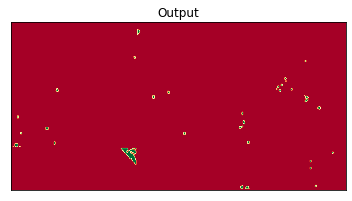

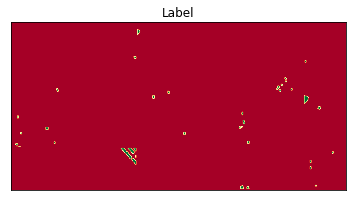

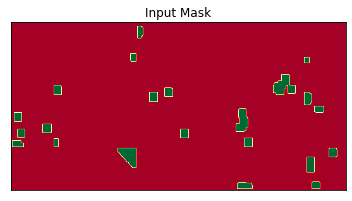

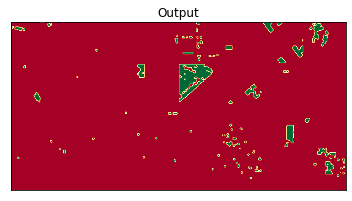

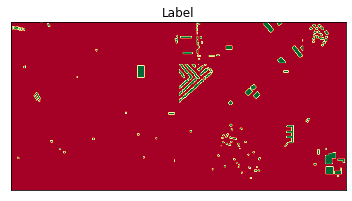

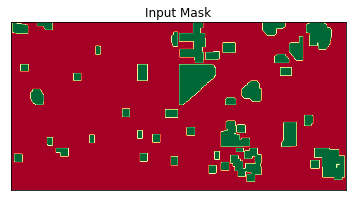

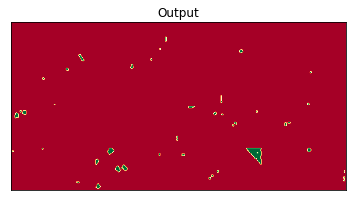

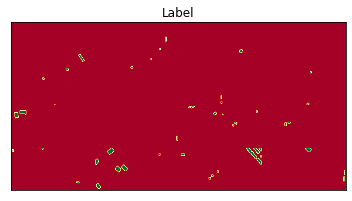

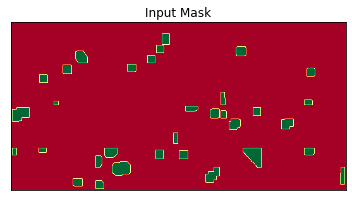

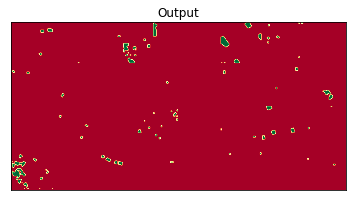

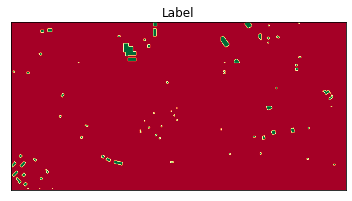

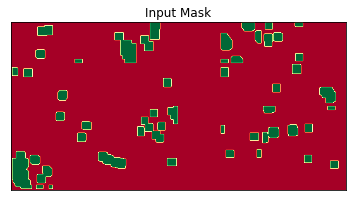

In [65]:
#print(example[0].shape)

for example in examples:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")

In [66]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop_basic(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        #img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output

        final_mask = out_mask.cpu()
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [67]:
basic_model = UNet(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(basic_model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [68]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()
losses_basic = []
examples_basic = []
metrics_all_basic = []

In [69]:

epoch = 50
for e in range(epoch):
    basic_model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch_basic = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        # img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = basic_model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch_basic.append(float(loss))
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1

    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch_basic)}")
    losses_basic = np.append(losses_basic, losses_epoch_basic)
    basic_model.eval()
    metrics, example, example_label, input_label = test_loop_basic(basic_model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples_basic.append((example,example_label,input_label))
    metrics_all_basic.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.28973262798129107


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9816758632659912; Dice 0.12204557661607396; Precision 0.21011866931803524; Specifity 0.9946642089635134; Recall0.10131919610103068
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.18422653074339618


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9836758626624942; Dice 0.1031185727093961; Precision 0.4062087725615129; Specifity 0.9969192612916231; Recall0.07603659101063924
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.1411733042419426


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9847119313975176; Dice 0.1703821943602609; Precision 0.4923050492846717; Specifity 0.9974154829978943; Recall0.1205338636552951
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.11002869205916022


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9853374394588172; Dice 0.24930409864721054; Precision 0.5174215323640965; Specifity 0.9969993634149432; Recall0.1964849816507221
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08630867067753799


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9857567764818669; Dice 0.3044395734460144; Precision 0.5321756682824343; Specifity 0.9965564701706171; Recall0.253860549320469
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.06907781791381949


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9854297849039236; Dice 0.32320716363199786; Precision 0.5161009084355707; Specifity 0.9958178860445818; Recall0.28082740622650393
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.055312109392459


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9859926362654993; Dice 0.35673915095208575; Precision 0.5430921769501376; Specifity 0.9960111866572073; Recall0.3078559266995388
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0450607950351839


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9863983960822225; Dice 0.3924370504040885; Precision 0.5536937882134225; Specifity 0.9957833411172032; Recall0.35313369366864344
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.036669315638269966


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9866782325423427; Dice 0.4232984688597139; Precision 0.5610485597151436; Specifity 0.9954124277250634; Recall0.39680378313331677
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.030842687655973623


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9869792552664876; Dice 0.4506325042292967; Precision 0.569755396596156; Specifity 0.9951843308284879; Recall0.433678140569945
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02657586087538736


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9873755665665324; Dice 0.472658567845866; Precision 0.5854312362445687; Specifity 0.9953281007368456; Recall0.4546729051800116
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.022818466941789378


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9877146704432865; Dice 0.4924189827442578; Precision 0.5964875317295082; Specifity 0.9953654521765808; Recall0.47649480215002255
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02068883552413991


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9880529243785602; Dice 0.510221013688162; Precision 0.6109145623094474; Specifity 0.9954995378278769; Recall0.49250391941266936
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018606090661519626


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9883452951908112; Dice 0.5239460304278699; Precision 0.6253864779635998; Specifity 0.9956668514226165; Recall0.5019611527241907
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.017269191849155454


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9886127139131228; Dice 0.5376693257098725; Precision 0.6352191074285656; Specifity 0.9957416133334239; Recall0.5152707380456857
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.015813942558652774


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9888397896429524; Dice 0.5506238554050522; Precision 0.6412291419546818; Specifity 0.9957346537848935; Recall0.5314642147769344
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014962994845540036


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9890664260396186; Dice 0.5619404723236956; Precision 0.6504995835917619; Specifity 0.9958326851620394; Recall0.5415365800505292
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014454132517961066


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.989265900105238; Dice 0.5731565443927489; Precision 0.6570025870654111; Specifity 0.9958671323127217; Recall0.5542818234842795
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01372846294429124


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9894619934064778; Dice 0.5831950559549685; Precision 0.6634737292280126; Specifity 0.9959140848368406; Recall0.5649750290950767
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013789389861791622


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.989623473957181; Dice 0.5908608726900317; Precision 0.6713687942246906; Specifity 0.9959966893307864; Recall0.5706044025181333
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01308668837845912


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9897818865165824; Dice 0.5987706171725002; Precision 0.6766023908941341; Specifity 0.9960383692135414; Recall0.5791367699899939
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012752132239113525


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9899262515828013; Dice 0.6057785957479566; Precision 0.6827997725181789; Specifity 0.9961015516045418; Recall0.5849390147103595
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01247488239442739


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9900597932384066; Dice 0.6129483607900745; Precision 0.6861376580883466; Specifity 0.9961063967126867; Recall0.5938213182874434
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012109459372325323


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9901725546612093; Dice 0.6192607699368975; Precision 0.6878778495884035; Specifity 0.9960800715101262; Recall0.6030223343538824
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.012058964950641193


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9902935124933719; Dice 0.6252711093220311; Precision 0.6929530171956867; Specifity 0.9961321807652712; Recall0.6085107909457763
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011796595574554614


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9904018028710897; Dice 0.6309812792307672; Precision 0.6956110138069982; Specifity 0.9961381444277672; Recall0.6157153431055714
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011425014043512835


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990513067830492; Dice 0.6363922526386783; Precision 0.6989949503482354; Specifity 0.9961624985077867; Recall0.6215182508598949
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011230586949134553


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990613099852843; Dice 0.6415241453613197; Precision 0.7022530715164196; Specifity 0.9961896895963166; Recall0.6269468266265804
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010815710474656322


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9907077852122742; Dice 0.6459868810893816; Precision 0.7050491213589778; Specifity 0.9962180277396893; Recall0.6317229855691633
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010492945055103325


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.990788076693813; Dice 0.6504451038765574; Precision 0.7064668064238504; Specifity 0.9962059472997983; Recall0.6380169990424381
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010426045498099383


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9908555878266212; Dice 0.6539885257355307; Precision 0.7083476574475607; Specifity 0.996210876491762; Recall0.6421427848972684
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010175959256616986


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909327360219322; Dice 0.6577275572766238; Precision 0.7111710937388125; Specifity 0.9962378151831217; Recall0.6457024170331719
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009523983976957718


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9909945957249764; Dice 0.6610378659541557; Precision 0.7125789026348767; Specifity 0.9962365928134231; Recall0.6498639824276681
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0091175278859565


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910533982602989; Dice 0.6644366236033391; Precision 0.7139466465656262; Specifity 0.9962278987993213; Recall0.6543028059044363
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00889605957112737


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911180694188391; Dice 0.6674138637378952; Precision 0.7164060800668917; Specifity 0.9962556676140853; Recall0.656898788065916
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008454275007660347


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911785733161701; Dice 0.6706881877927039; Precision 0.7179946464732185; Specifity 0.9962569549679756; Recall0.6608794519585923
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008018239723027162


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991228327205455; Dice 0.6733652447790444; Precision 0.7193168614600861; Specifity 0.9962597588530263; Recall0.6640472086107462
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007310321799288761


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912736591343817; Dice 0.6759560684489314; Precision 0.7205838713929743; Specifity 0.9962600230386383; Recall0.6671394843227038
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007298855796661668


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913117487270099; Dice 0.678179700917362; Precision 0.7212778841300557; Specifity 0.9962523132562637; Recall0.6700704575073312
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006810104510174903


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913602220825851; Dice 0.6802088009530801; Precision 0.7237419899029192; Specifity 0.9962876736186445; Recall0.6711545285034229
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006372645785152091


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914000343713092; Dice 0.6824683154830602; Precision 0.7245087051571052; Specifity 0.9962806791612288; Recall0.6741879608038044
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006111813412143255


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914410022043046; Dice 0.6843959649991184; Precision 0.7256722053723588; Specifity 0.9962916373319569; Recall0.6761618697582303
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00574468207677577


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914800490924093; Dice 0.686446939171585; Precision 0.7265521358471191; Specifity 0.9962919337545023; Recall0.6787141360698791
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005407270644956422


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9915143947794356; Dice 0.6883305686578605; Precision 0.7274381649119526; Specifity 0.9962929169308733; Recall0.6809765038428703
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005205153400082083


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991549029863543; Dice 0.6903358492472215; Precision 0.7281526077073067; Specifity 0.9962880602313413; Recall0.6836693525489216
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005213764833477069


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991581674867674; Dice 0.6921260165667835; Precision 0.7288960987732381; Specifity 0.9962900956363782; Recall0.6859271098099368
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004690736424962543


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916099930935084; Dice 0.6937277662517966; Precision 0.7296106454252483; Specifity 0.9962896507312643; Recall0.6878776940823278
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004352763805292752


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916377596091479; Dice 0.6954226284568922; Precision 0.7300252667579722; Specifity 0.9962808991549537; Recall0.6903425144428429
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004160838223641782


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916643766420228; Dice 0.696941515078208; Precision 0.730446768615737; Specifity 0.9962757864244738; Recall0.692429801807359
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0038468423565321667


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9916899079084396; Dice 0.69818698978887; Precision 0.7315049552498385; Specifity 0.9962861945480108; Recall0.6933940862276594
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


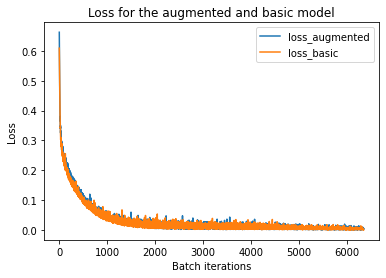

In [85]:
plt.plot(losses[381:], label= "loss_augmented")
plt.plot(losses_basic, label= "loss_basic")
plt.xlabel("Batch iterations")
plt.ylabel("Loss")
plt.title("Loss for the augmented and basic model")
plt.legend()

Text(0.5, 1.0, 'Dice metric for augmented and basic model')

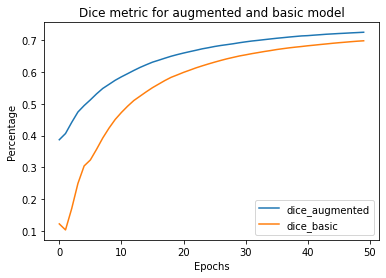

In [82]:
#plt.plot([metr[0] for metr in metrics_all[3:]], label="accuracy_augmented")
plt.plot([metr[1] for metr in metrics_all[3:]], label= "dice_augmented")
#plt.plot([metr[0] for metr in metrics_all_basic], label="accuracy_basic")
plt.plot([metr[1] for metr in metrics_all_basic], label= "dice_basic")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()
plt.title("Dice metric for augmented and basic model")

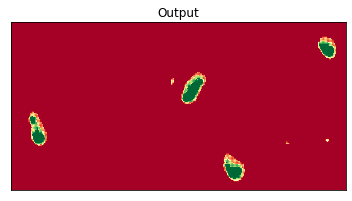

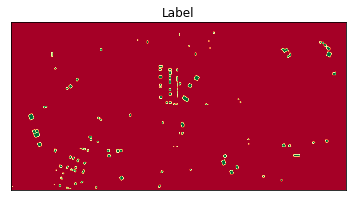

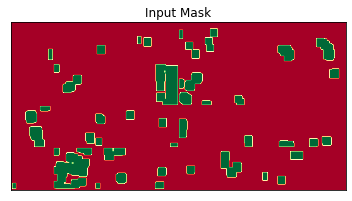

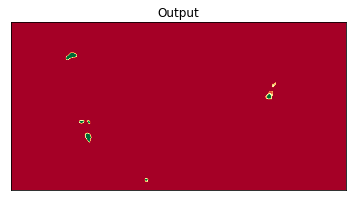

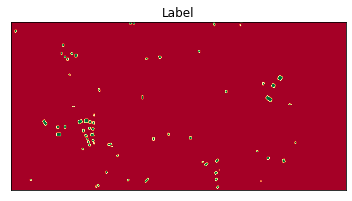

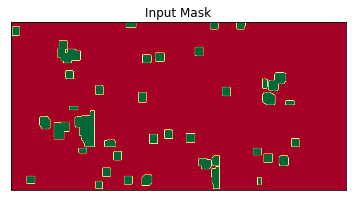

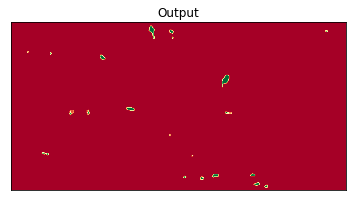

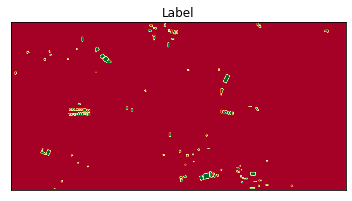

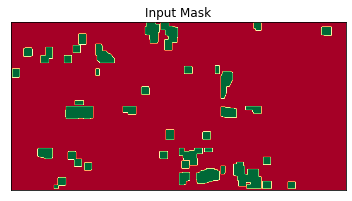

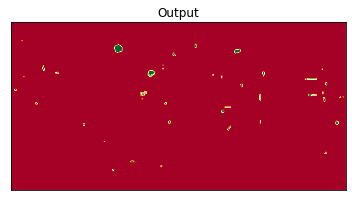

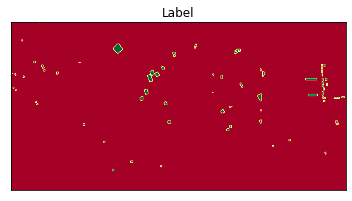

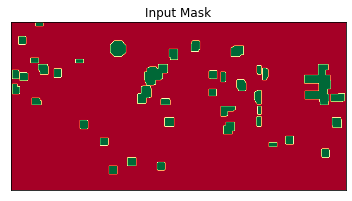

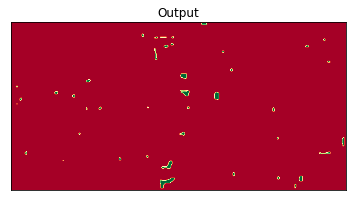

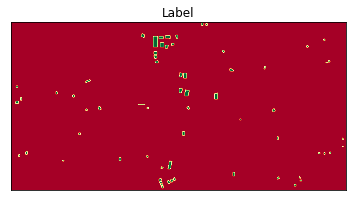

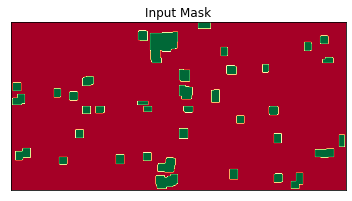

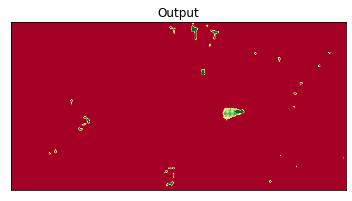

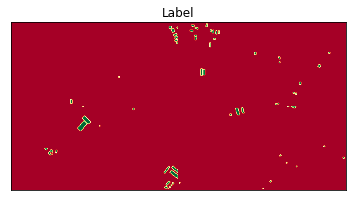

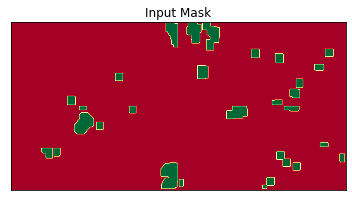

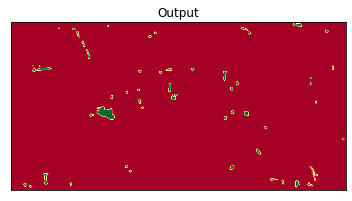

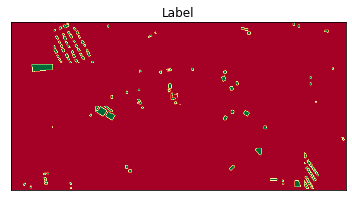

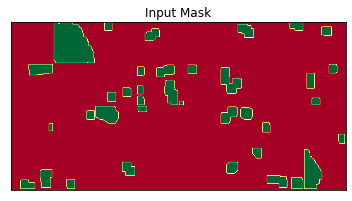

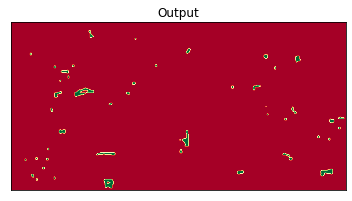

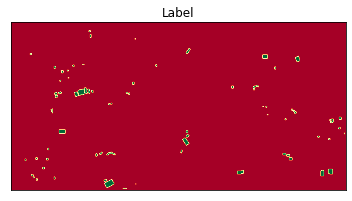

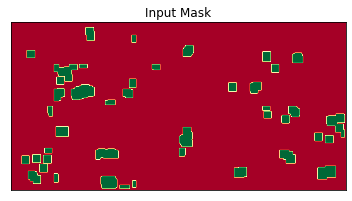

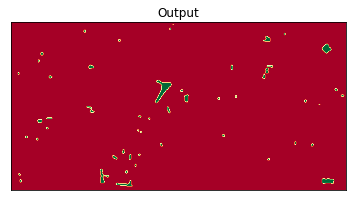

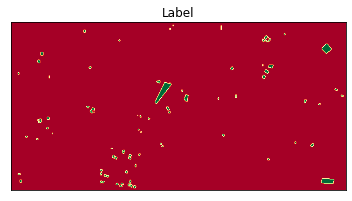

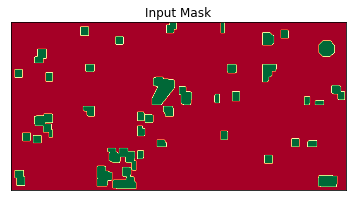

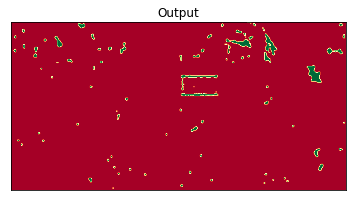

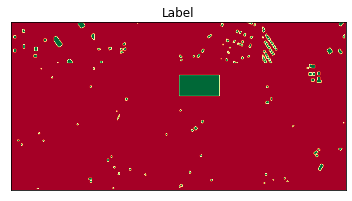

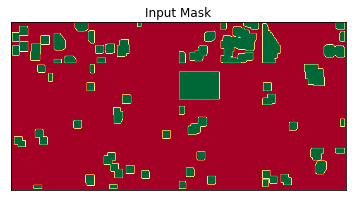

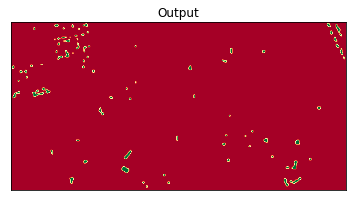

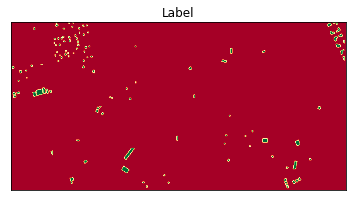

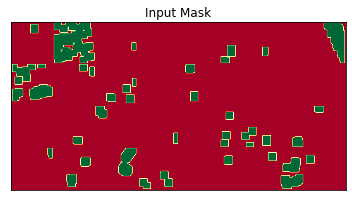

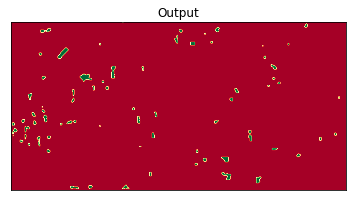

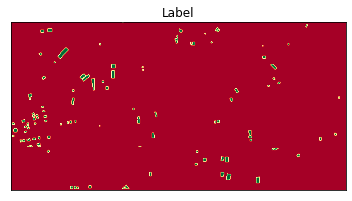

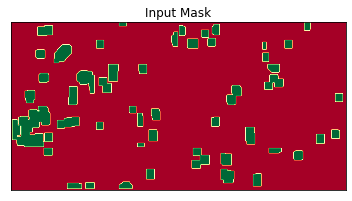

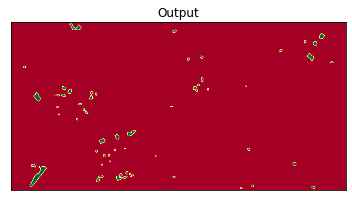

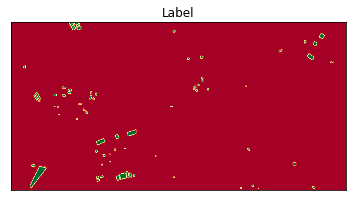

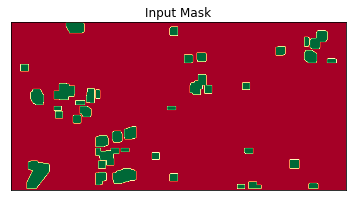

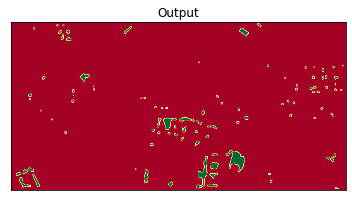

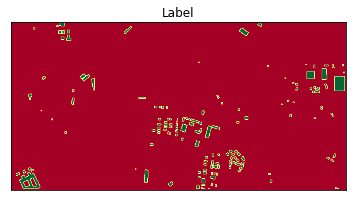

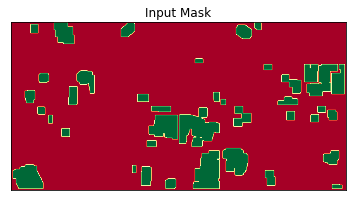

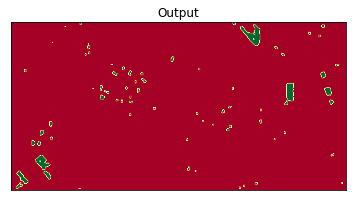

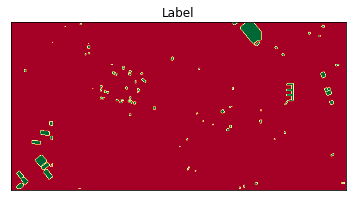

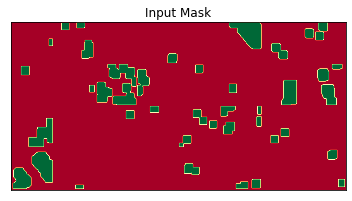

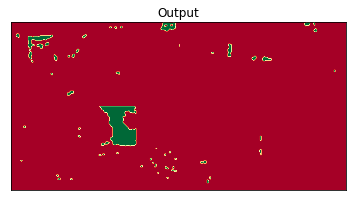

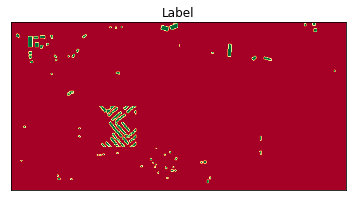

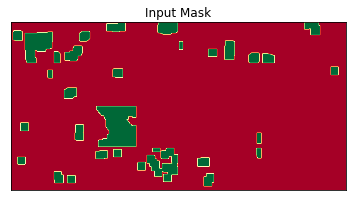

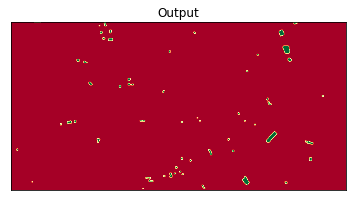

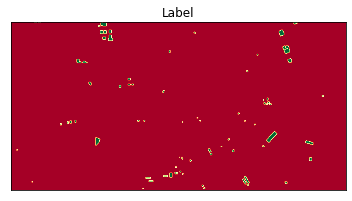

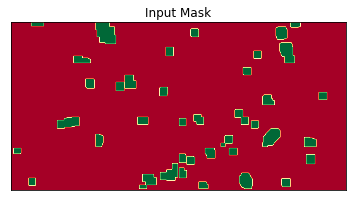

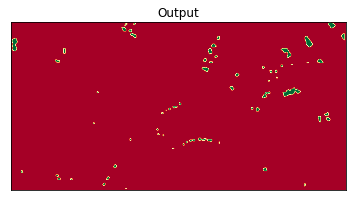

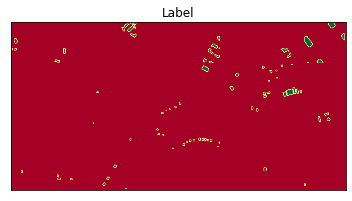

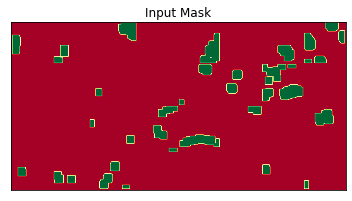

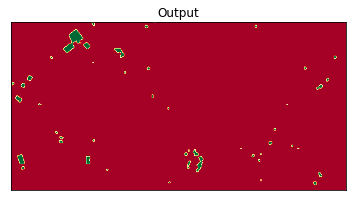

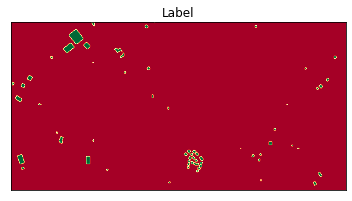

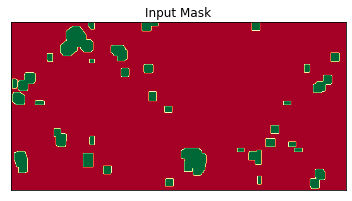

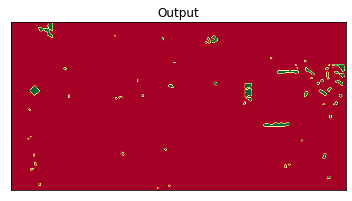

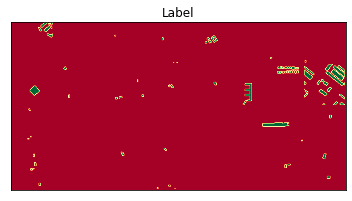

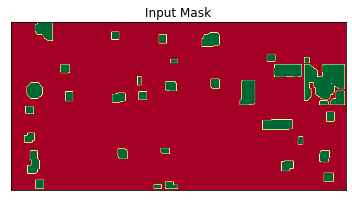

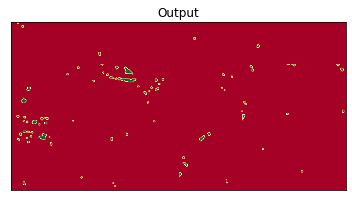

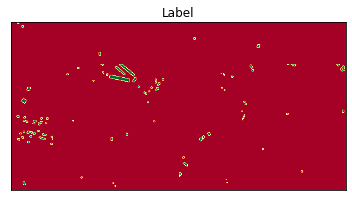

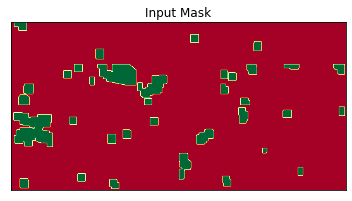

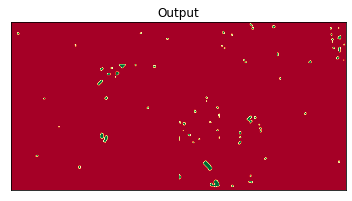

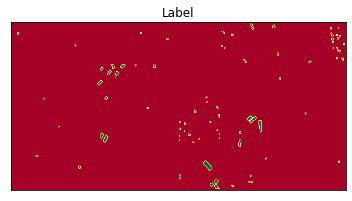

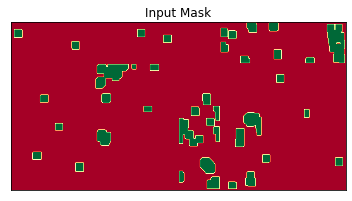

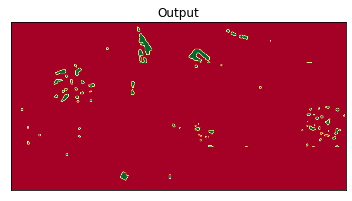

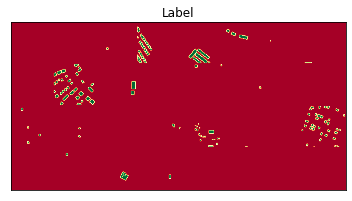

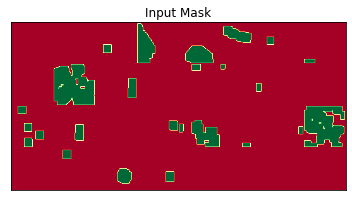

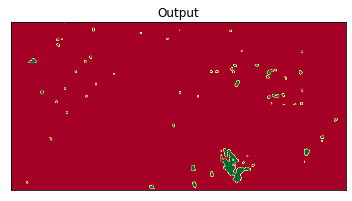

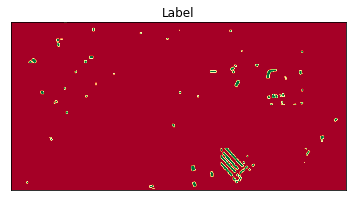

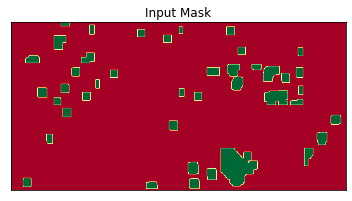

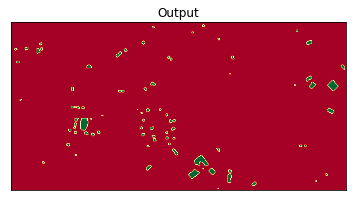

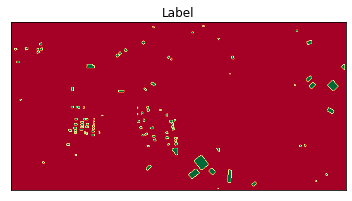

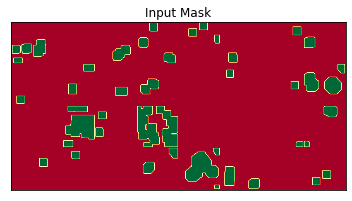

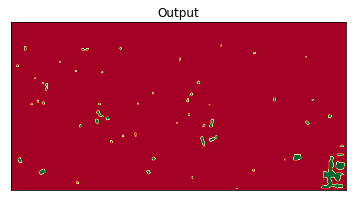

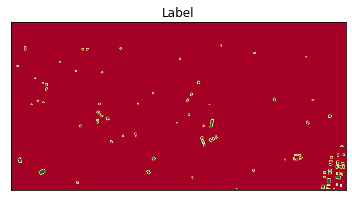

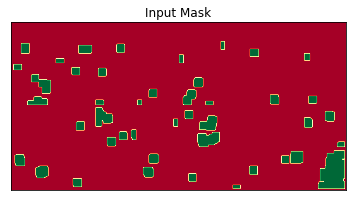

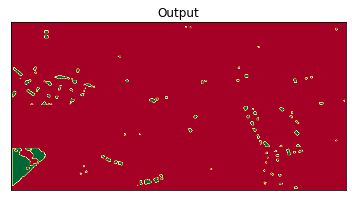

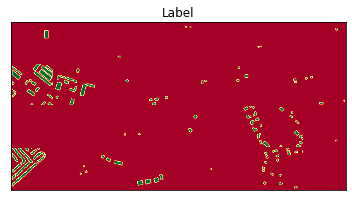

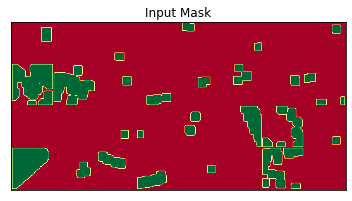

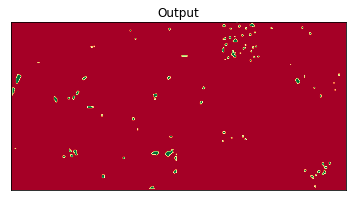

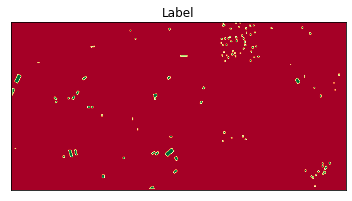

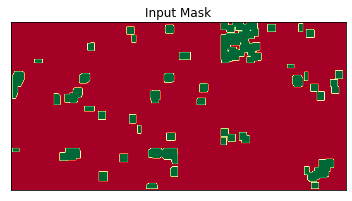

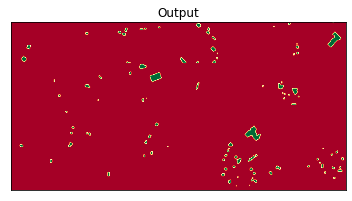

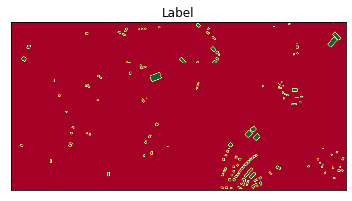

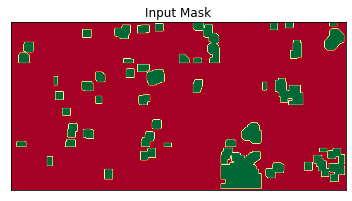

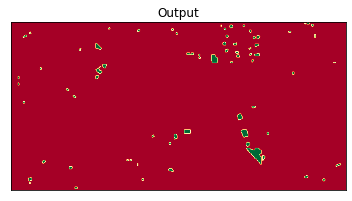

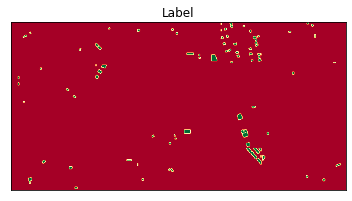

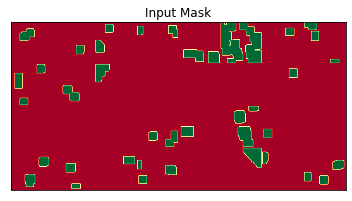

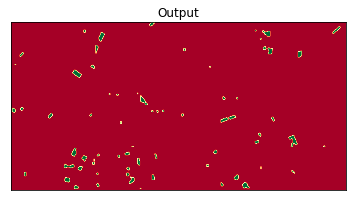

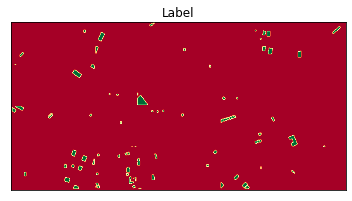

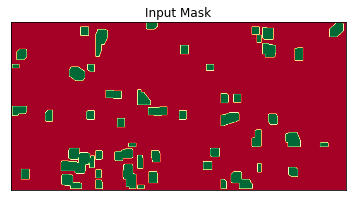

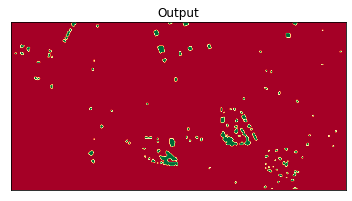

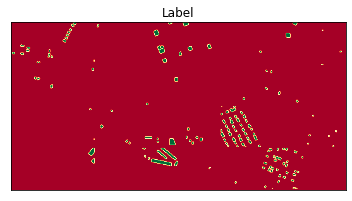

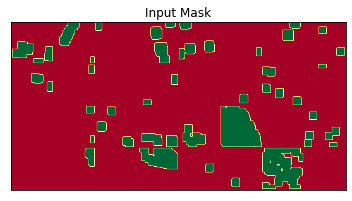

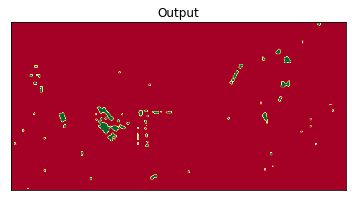

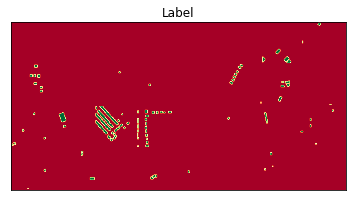

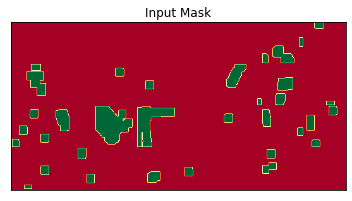

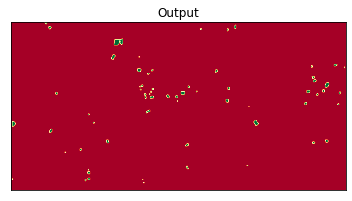

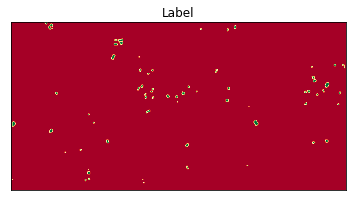

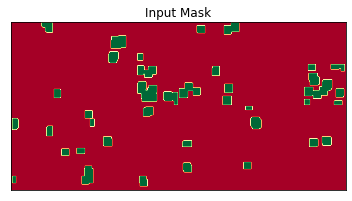

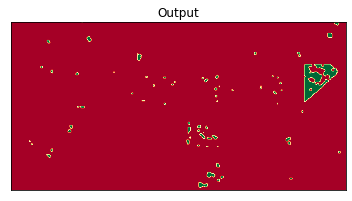

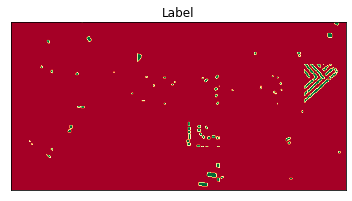

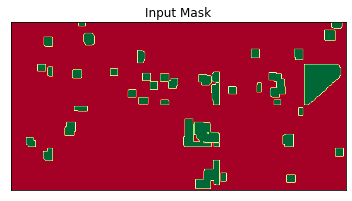

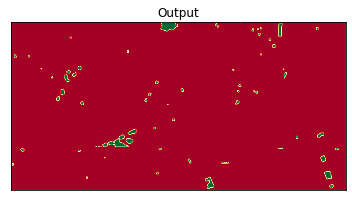

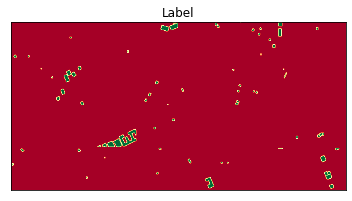

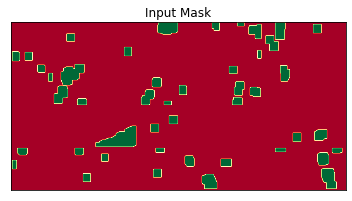

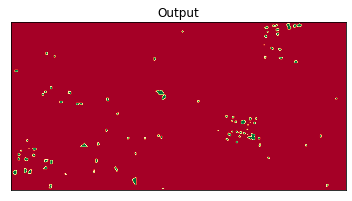

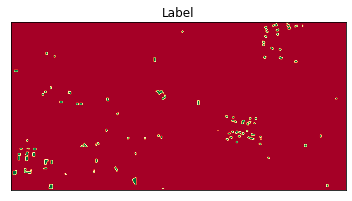

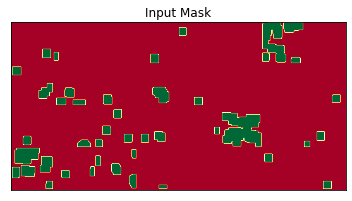

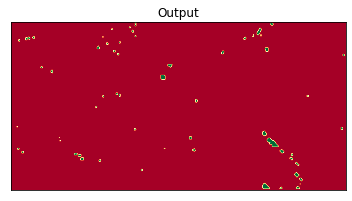

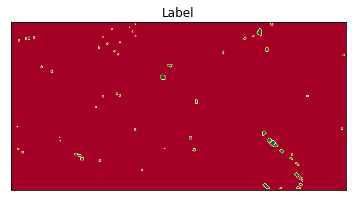

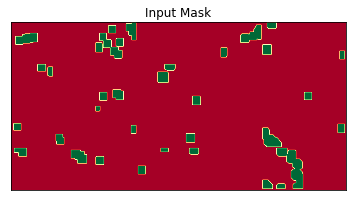

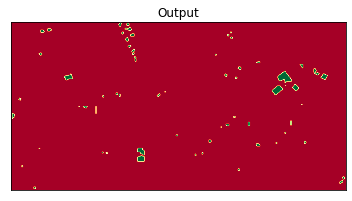

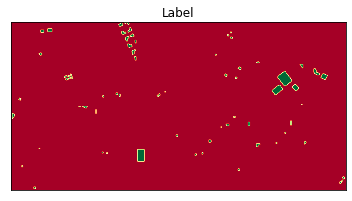

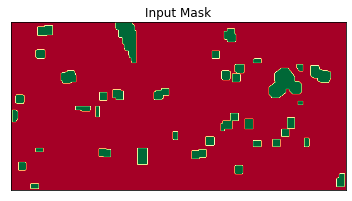

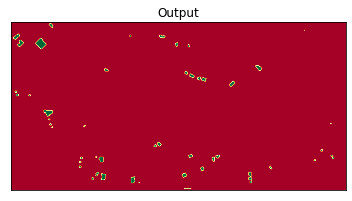

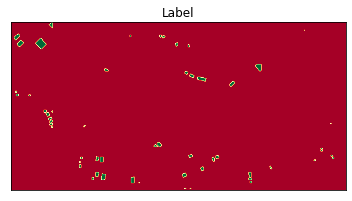

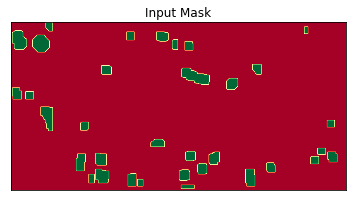

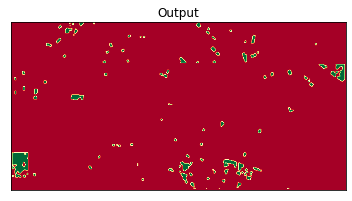

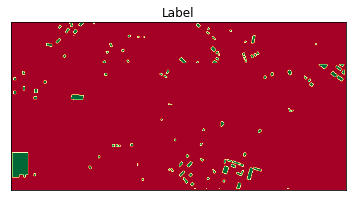

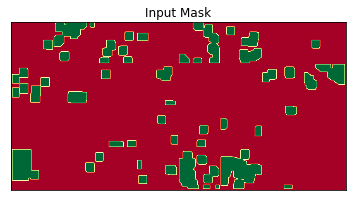

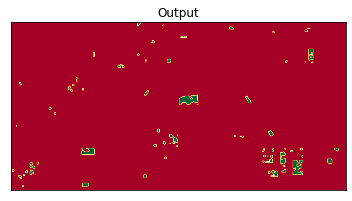

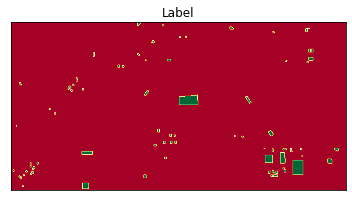

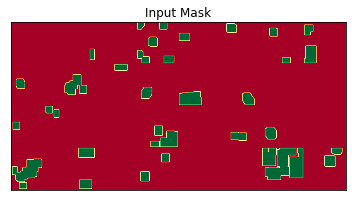

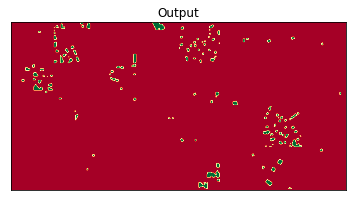

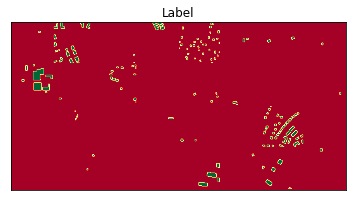

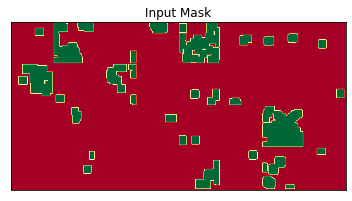

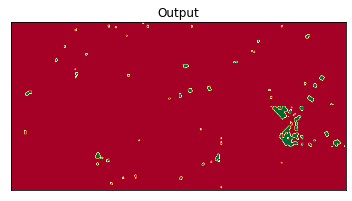

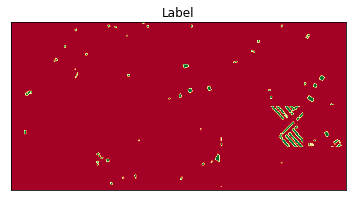

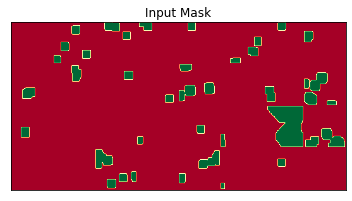

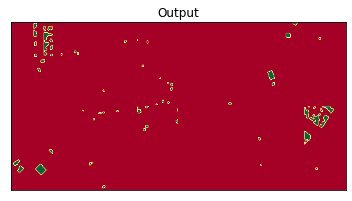

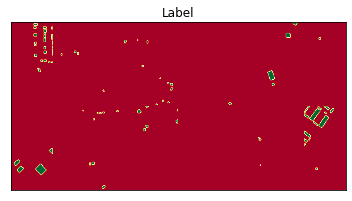

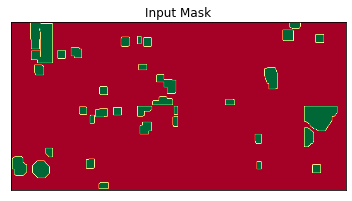

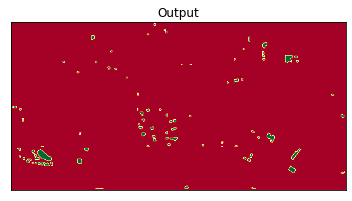

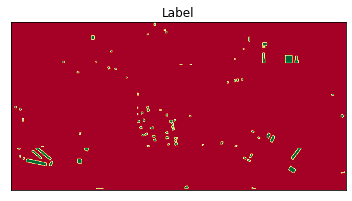

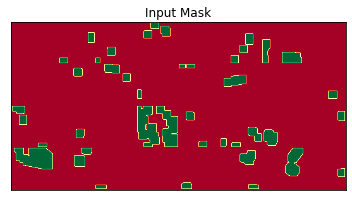

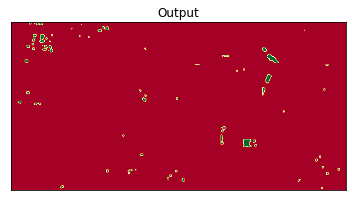

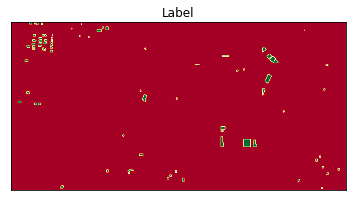

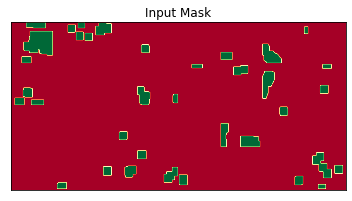

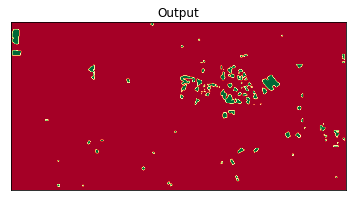

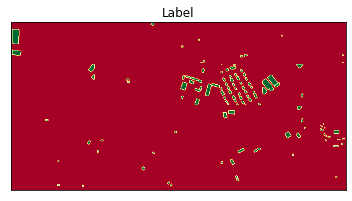

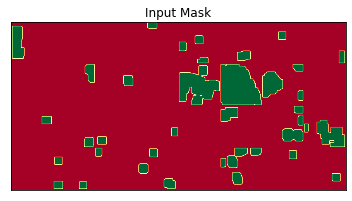

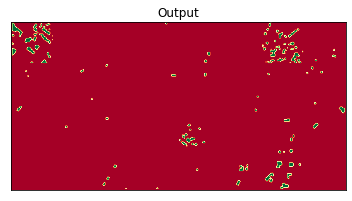

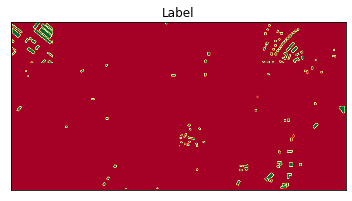

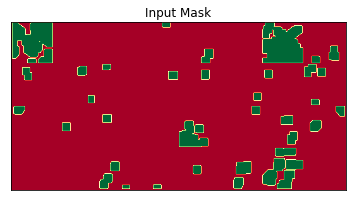

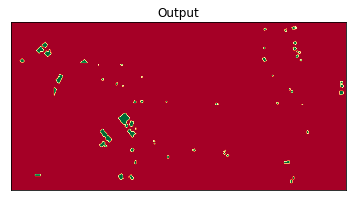

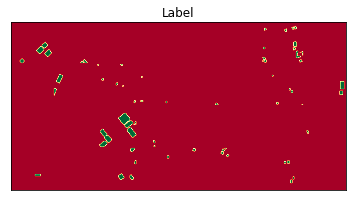

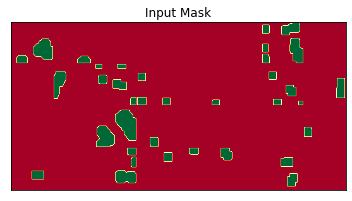

In [72]:
#print(example[0].shape)

for example in examples_basic:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")

In [73]:
# missing evaluation for complete masked input
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
img_middle = img_middle.type(torch.float32).cuda()
gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)

output = basic_model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))

sig = torch.nn.Sigmoid()
final_mask = sig(output)
final_mask = final_mask.cpu().detach().numpy()

output = np.zeros_like(final_mask)
#print("----")
#print(example.shape)
output[final_mask>0.5] = 1
print(output.shape)

(32, 1, 64, 64)


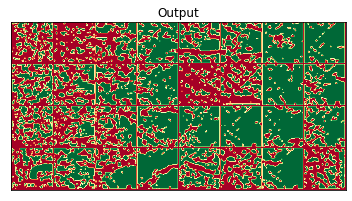

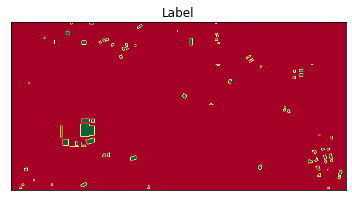

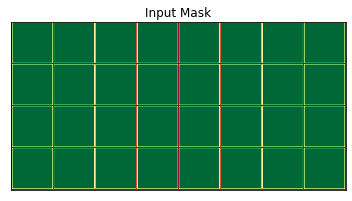

In [74]:
show_batch_images(torch.tensor(output),16, "Output")
show_batch_images(gt.cpu(),16, "Label")
show_batch_images(label_interest.unsqueeze(1).type(torch.float32).cpu().type(torch.float32),16, "Input Mask")

In [75]:
# missing evaluation for complete masked input
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
img_middle = img_middle.type(torch.float32).cuda()
img_before = img_before.type(torch.float32).cuda()
gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)

output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                     torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))

sig = torch.nn.Sigmoid()
final_mask = sig(output)
final_mask = final_mask.cpu().detach().numpy()

output = np.zeros_like(final_mask)
#print("----")
#print(example.shape)
output[final_mask>0.5] = 1
print(output.shape)

(32, 1, 64, 64)


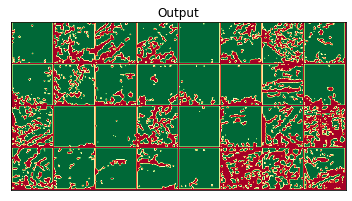

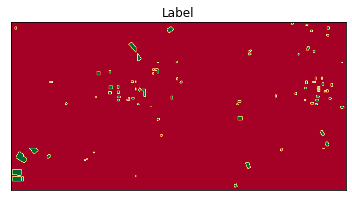

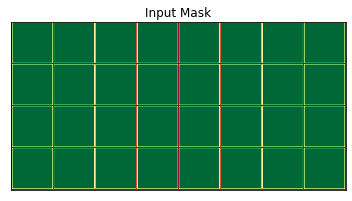

In [76]:
show_batch_images(torch.tensor(output),16, "Output")
show_batch_images(gt.cpu(),16, "Label")
show_batch_images(label_interest.unsqueeze(1).type(torch.float32).cpu().type(torch.float32),16, "Input Mask")

In [100]:
model_4 = UNet_double_down(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [101]:
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(model_4.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [102]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [103]:

epoch = 50
examples_between = []
metrics_between = []
losses_between = []
for e in range(epoch):
    model_4.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        #label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = model_4(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                       torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(output.grad)
        
        losses_epoch.append(float(loss))
        #break
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
        #break
    #break
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses_between = np.append(losses_between, losses_epoch)
    model_4.eval()
    metrics, example, example_label, input_label = test_loop(model_4,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples_between.append((example,example_label,input_label))
    metrics_between.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.3911756664279878


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912079540776069; Dice 0.6791386107442446; Precision 0.7068887386594879; Specifity 0.9958545351716062; Recall0.6868193343695407
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2728077789225916


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911562332810774; Dice 0.6757956246781324; Precision 0.7049667764143662; Specifity 0.9958547545108513; Recall0.6828206823060919
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.21658413006564764


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911125910704403; Dice 0.6725885896467851; Precision 0.7036617202571489; Specifity 0.9958663017613362; Recall0.6788101731779155
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.1727916908076429


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910786568088058; Dice 0.6714222501757995; Precision 0.702693596419271; Specifity 0.9958518940909111; Recall0.6773557015417861
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.13808954935374224


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910561908964302; Dice 0.6712979063980211; Precision 0.7017456982627862; Specifity 0.9958188782002623; Recall0.6779876555222284
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.11050907035512249


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910407165105964; Dice 0.6712261381287443; Precision 0.7011042471773175; Specifity 0.9957979012694184; Recall0.6783137831520808
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08891210024516413


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991035943645876; Dice 0.6712306549785274; Precision 0.7009124776039384; Specifity 0.9957954906331293; Recall0.6782828092659834
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.07184593933891123


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910362453435794; Dice 0.6713235104260943; Precision 0.7011326627785286; Specifity 0.9957998745435211; Recall0.678092329420248
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.058289576791168196


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910310416070987; Dice 0.6712975916767553; Precision 0.7011351619432706; Specifity 0.9957984409944681; Recall0.6778646171083741
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.04766459821716068


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910341054124592; Dice 0.6717374832270276; Precision 0.7013368517648204; Specifity 0.9957960870061462; Recall0.6783727318620965
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.039219591898594315


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910383477419903; Dice 0.6722004210444428; Precision 0.7014362464538768; Specifity 0.9957923670842583; Recall0.6790525651293888
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.033229130400916726


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910484735654905; Dice 0.672585431342731; Precision 0.7021584501931308; Specifity 0.9958056188581447; Recall0.678952543935794
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.028099161609420626


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910563026305129; Dice 0.672865245789467; Precision 0.7028633539104036; Specifity 0.9958151579052583; Recall0.6787892505659509
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.024677326404086247


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910689097385037; Dice 0.6734960745238251; Precision 0.7035243013420659; Specifity 0.9958238553224305; Recall0.6792214185405538
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.021554161288489505


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9910798035617173; Dice 0.673951915280492; Precision 0.7044229344553403; Specifity 0.9958386640420499; Recall0.6791645776910871
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018947634508642626


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.99108964099758; Dice 0.6746477400509225; Precision 0.704788147543769; Specifity 0.9958365649145372; Recall0.6800372010802046
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01737797541147846


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911027315781498; Dice 0.6753714354544963; Precision 0.7052694011841362; Specifity 0.995840868986365; Recall0.680796374942043
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.016126474900919154


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911158471796886; Dice 0.6760376241743835; Precision 0.7058857525269202; Specifity 0.9958471188487776; Recall0.6813651666819345
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.015119082976396627


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911297837950179; Dice 0.6766110976100493; Precision 0.7067000176689766; Specifity 0.9958594182157904; Recall0.6815871540984728
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014074136726704873


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911442556169625; Dice 0.677256514213875; Precision 0.7073609064454588; Specifity 0.9958690478160136; Recall0.682064198797555
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013372563460005784


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911599418659902; Dice 0.6779232179750332; Precision 0.7081323046770562; Specifity 0.9958796369905917; Recall0.682467431372425
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01280889661403329


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911746239483831; Dice 0.6786189263244955; Precision 0.7086432570897115; Specifity 0.9958836927961222; Recall0.6831891016549975
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01240730377310139


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9911862566963426; Dice 0.6792913017214435; Precision 0.7089241661782988; Specifity 0.995882615813523; Recall0.6840732605045203
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011829185107077552


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912017644247884; Dice 0.6800153692316768; Precision 0.7096011038900403; Specifity 0.9958904423591785; Recall0.6846647983009737
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01162966334730328


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912145133153674; Dice 0.6806719026275689; Precision 0.7099240481538257; Specifity 0.995891738425775; Recall0.6854442828304986
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.011142551726624957


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912280498095334; Dice 0.6812982417069735; Precision 0.7104505646851994; Specifity 0.9958975599994997; Recall0.6860011681710068
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010814874938058513


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912429848008458; Dice 0.6820228220205696; Precision 0.7108607371695618; Specifity 0.9958997508489962; Recall0.6868353220021324
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.010353460753937876


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912564598073895; Dice 0.6827078841188194; Precision 0.7114222253073882; Specifity 0.9959066168440535; Recall0.6874438005157777
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01037425430322902


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912698358390025; Dice 0.6833975361874357; Precision 0.7117205211223198; Specifity 0.9959065950827724; Recall0.6883362893783386
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009678206725530034


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.991284816747307; Dice 0.6840267955354631; Precision 0.7122706874105594; Specifity 0.9959135173462959; Recall0.6888535261027984
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.009355324479993286


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9912959608105364; Dice 0.6846880560496801; Precision 0.7124055710437099; Specifity 0.9959088748241797; Recall0.6898962634418089
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00918258785354487


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913107724021756; Dice 0.6853217020214315; Precision 0.7128970897587493; Specifity 0.995915288702723; Recall0.6904786644686105
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00892415114194448


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913246052182776; Dice 0.6860314879810949; Precision 0.7133689895959285; Specifity 0.9959190631144506; Recall0.6912180594908766
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.008372230809108596


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913378473721263; Dice 0.6867178667943921; Precision 0.7137574907267511; Specifity 0.9959203098424767; Recall0.692028979404656
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007973728677639224


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913485381874472; Dice 0.6872839100057245; Precision 0.7139766942363567; Specifity 0.9959190920992105; Recall0.6927885019865564
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007468002415665491


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913614519536369; Dice 0.6879514308907155; Precision 0.7144705382672643; Specifity 0.9959223489487923; Recall0.6934561230956737
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0073928445262291765


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913709012461891; Dice 0.6884735661368864; Precision 0.7147540276479344; Specifity 0.9959232883951452; Recall0.6940350949142912
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.007183957138230774


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913798454534535; Dice 0.689009448684791; Precision 0.7148858398769836; Specifity 0.9959201124615361; Recall0.694824108918675
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.006356732473859021


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913923917890634; Dice 0.6896369586211535; Precision 0.7152658567578744; Specifity 0.995922311676928; Recall0.6955306103624096
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0063886401348006655


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9913972927112367; Dice 0.6900701122188755; Precision 0.7153359542472935; Specifity 0.995917308254403; Recall0.6962086754524036
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005878556439081046


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914066146691706; Dice 0.6906010825632158; Precision 0.7154150406306504; Specifity 0.9959137342989176; Recall0.6970580167844567
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0055246272492845815


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914162505831646; Dice 0.6910571728447008; Precision 0.7157947964531411; Specifity 0.9959182168299127; Recall0.6974219251721321
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005081500415323581


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914227321412828; Dice 0.6913915932580302; Precision 0.7159484563582683; Specifity 0.9959187655135838; Recall0.6978005791028351
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.005097213409764062


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914300104955361; Dice 0.6918479706466854; Precision 0.7161778769006736; Specifity 0.9959184218725973; Recall0.6983238094525863
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004680935336518886


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914382801476255; Dice 0.6923101388929858; Precision 0.7162778734053701; Specifity 0.9959162709886066; Recall0.6990221606938556
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004596533040437246


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914477429737707; Dice 0.6927404882713306; Precision 0.7165484414950036; Specifity 0.9959186375897128; Recall0.6994546761179189
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.004128405996176641


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914576587314539; Dice 0.6931784926429054; Precision 0.7169525563820973; Specifity 0.9959242703784118; Recall0.6997647258656953
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.00405719937430328


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914659759653058; Dice 0.693642668975273; Precision 0.7171045839271754; Specifity 0.9959236279975645; Recall0.7003862821383963
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.003840904912955355


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914762160046376; Dice 0.6940977935327449; Precision 0.7175069757189785; Specifity 0.9959283812715589; Recall0.7007350201511245
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0038598293858382294


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9914848538821942; Dice 0.6945276590463698; Precision 0.7177790465065853; Specifity 0.9959307261931652; Recall0.7011652197812956
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


Text(0.5, 1.0, 'Dice metric for augmented and basic model')

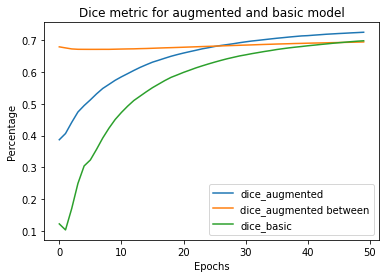

In [104]:
#plt.plot([metr[0] for metr in metrics_all[3:]], label="accuracy_augmented")
plt.plot([metr[1] for metr in metrics_all[3:]], label= "dice_augmented")
plt.plot([metr[1] for metr in metrics_between], label= "dice_augmented between")
#plt.plot([metr[0] for metr in metrics_all_basic], label="accuracy_basic")
plt.plot([metr[1] for metr in metrics_all_basic], label= "dice_basic")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()
plt.title("Dice metric for augmented and basic model")

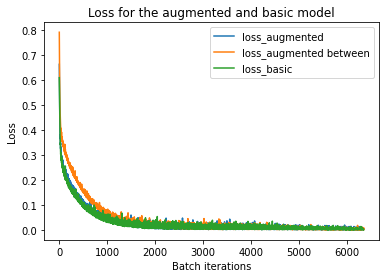

In [105]:
plt.plot(losses[381:], label= "loss_augmented")
plt.plot(losses_between, label= "loss_augmented between")
plt.plot(losses_basic, label= "loss_basic")
plt.xlabel("Batch iterations")
plt.ylabel("Loss")
plt.title("Loss for the augmented and basic model")
plt.legend()

In [ ]:
# missing evaluation for complete masked input
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
label_interest = torch.tensor(np.ones_like(label_interest)).cuda()
img_middle = img_middle.type(torch.float32).cuda()
gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)

output = model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))

sig = torch.nn.Sigmoid()
final_mask = sig(output)
final_mask = final_mask.cpu().detach().numpy()

output = np.zeros_like(final_mask)
#print("----")
#print(example.shape)
output[final_mask>0.5] = 1
print(output.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


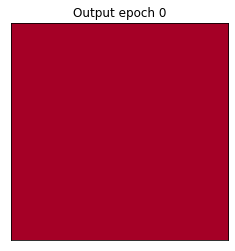

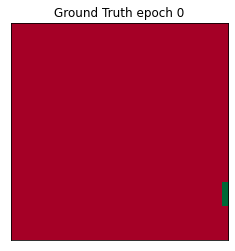

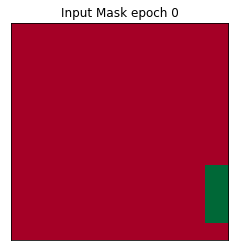

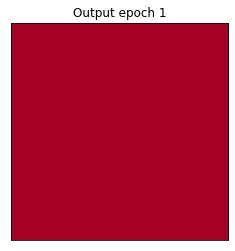

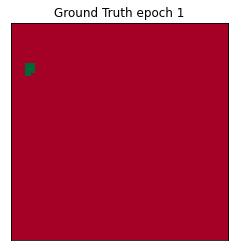

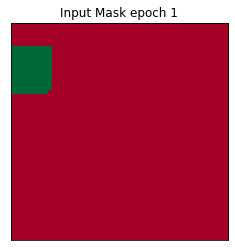

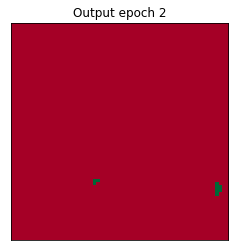

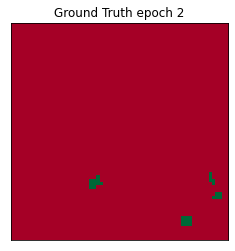

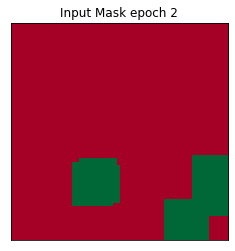

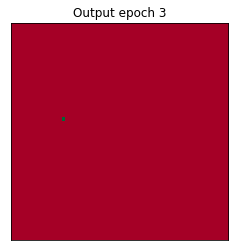

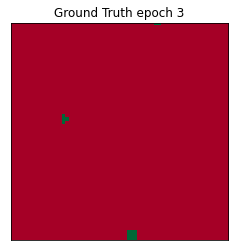

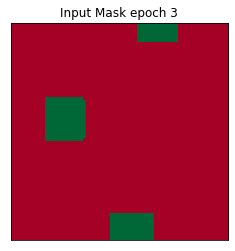

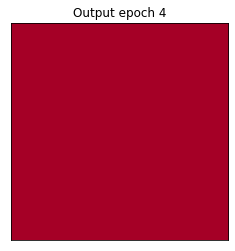

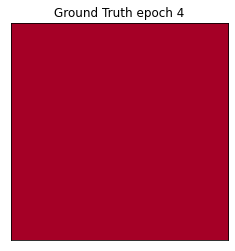

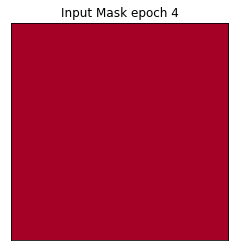

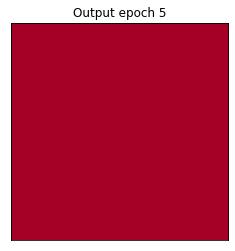

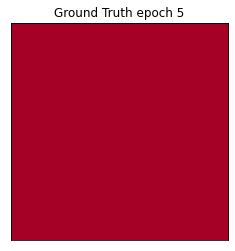

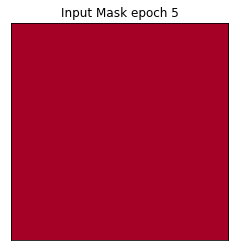

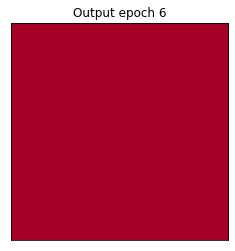

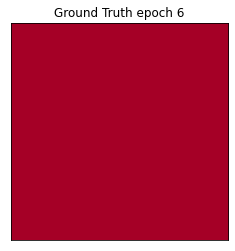

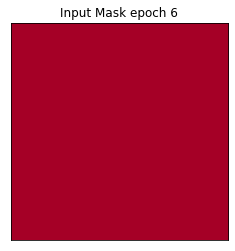

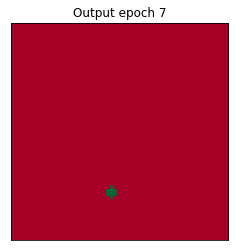

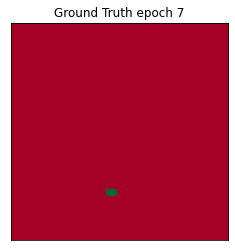

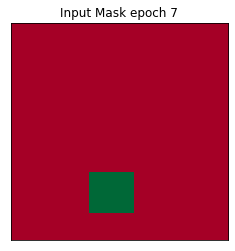

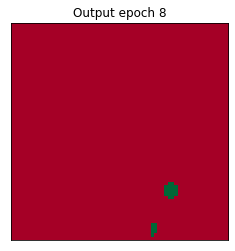

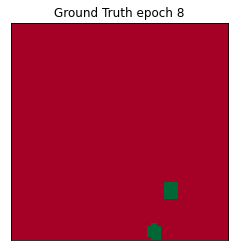

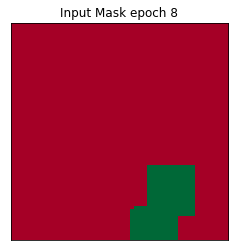

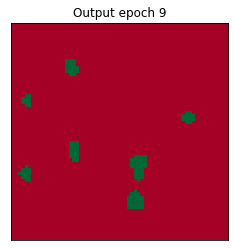

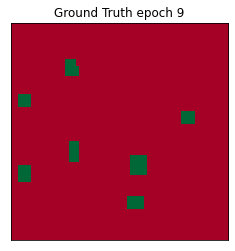

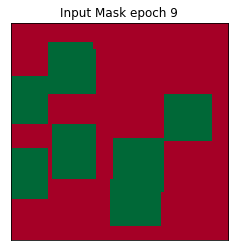

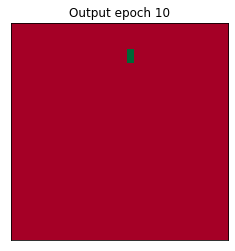

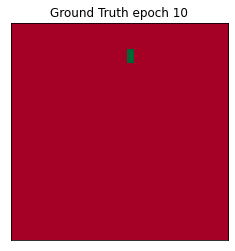

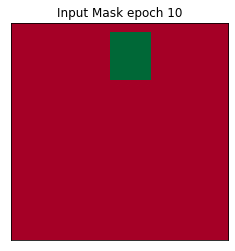

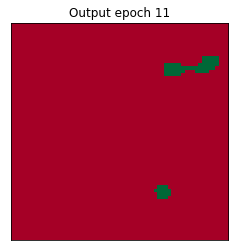

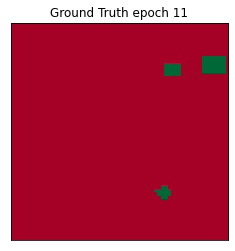

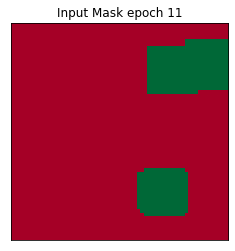

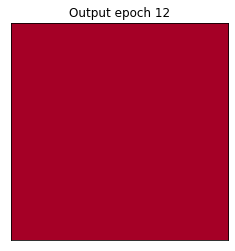

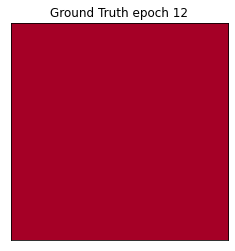

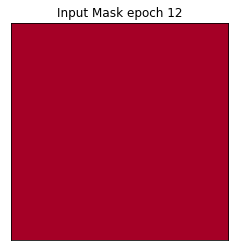

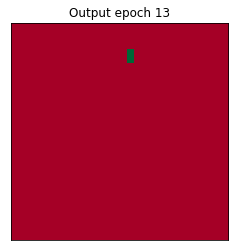

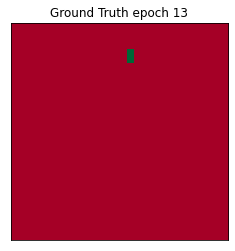

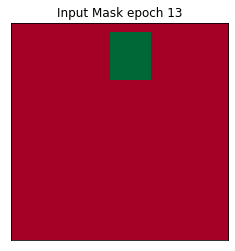

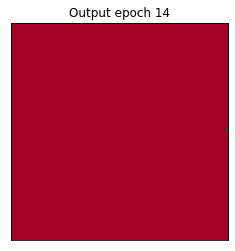

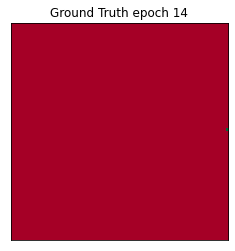

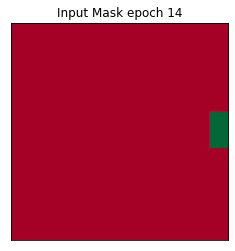

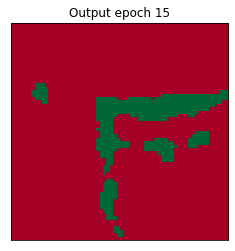

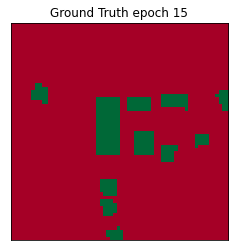

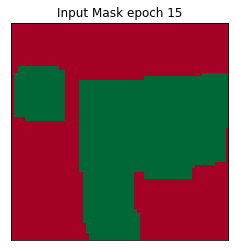

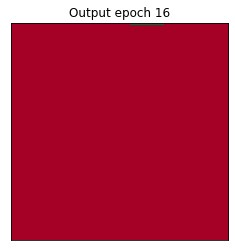

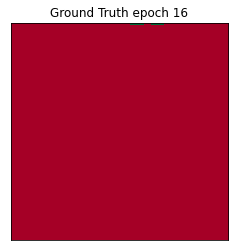

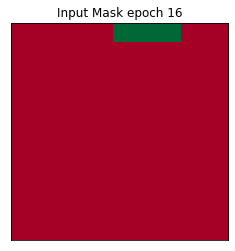

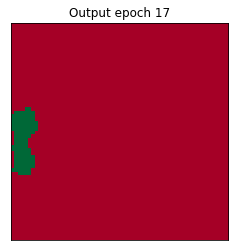

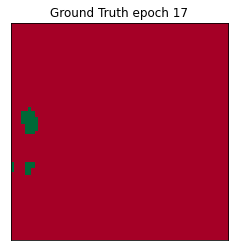

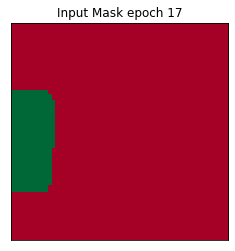

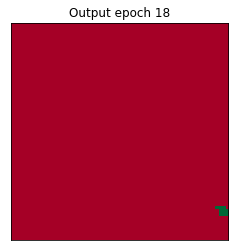

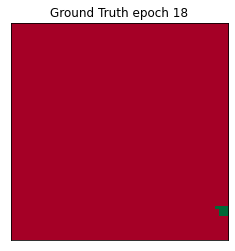

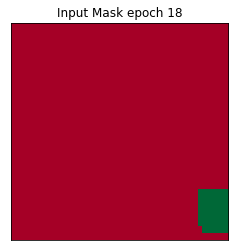

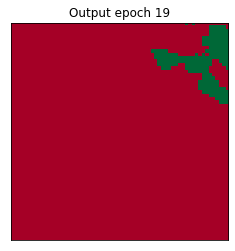

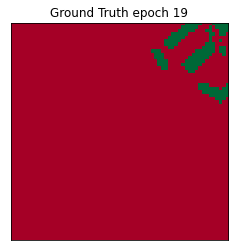

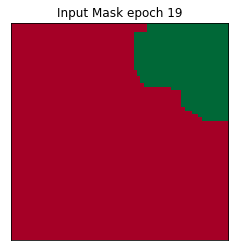

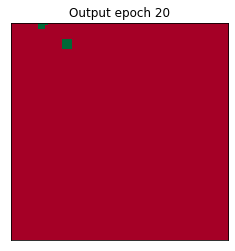

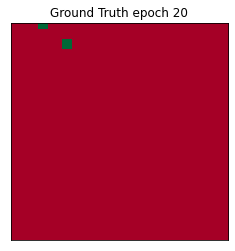

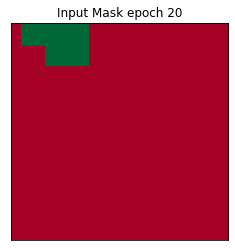

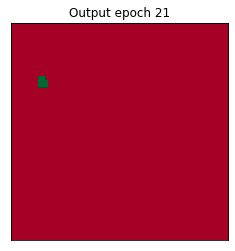

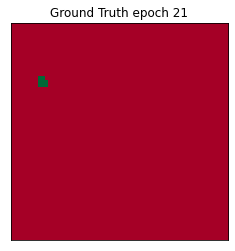

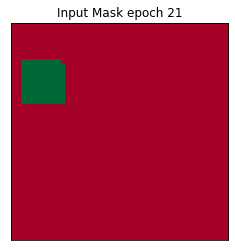

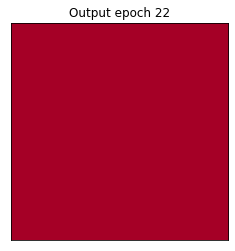

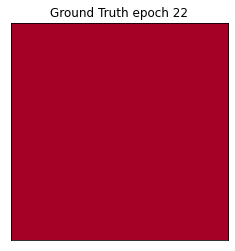

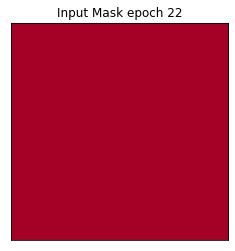

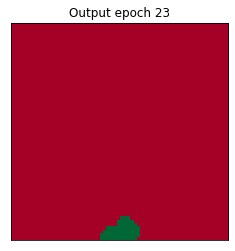

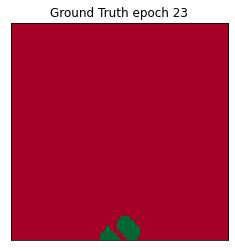

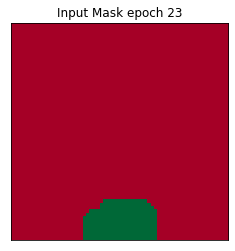

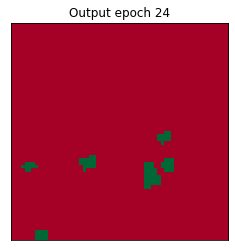

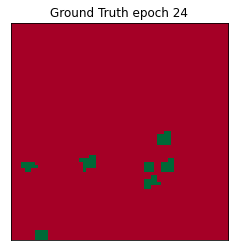

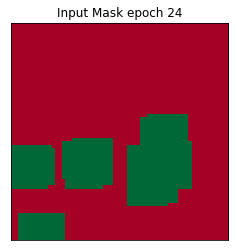

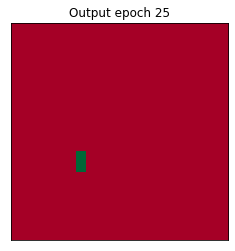

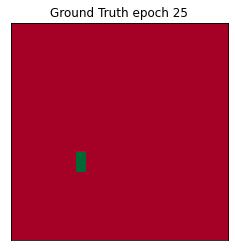

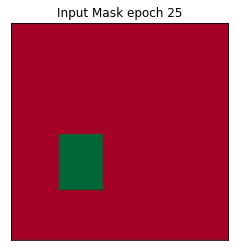

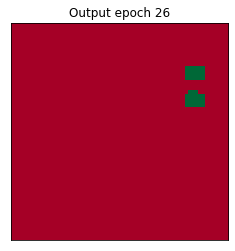

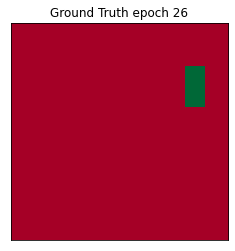

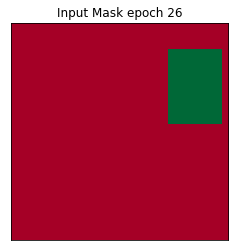

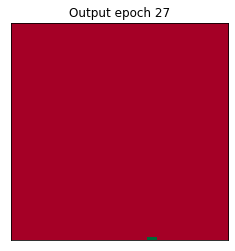

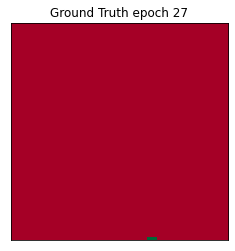

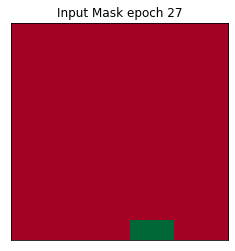

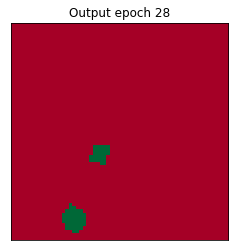

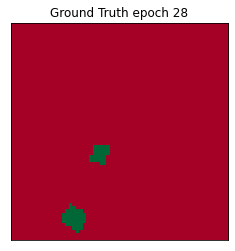

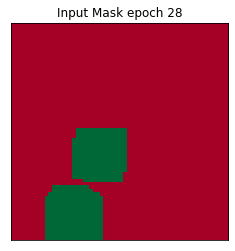

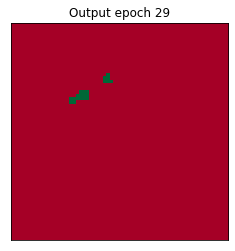

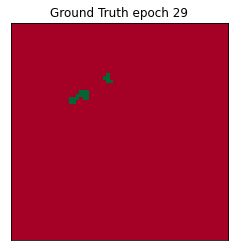

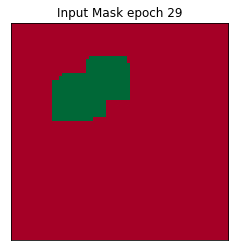

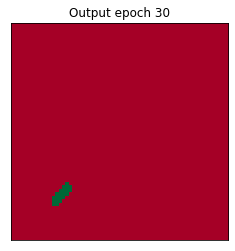

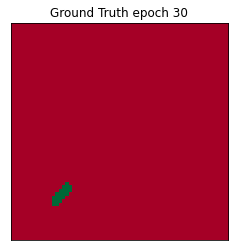

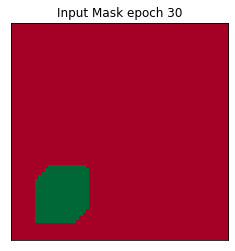

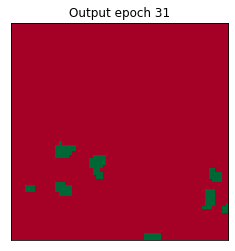

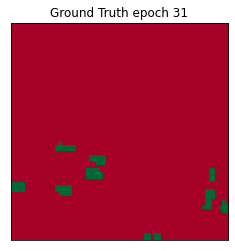

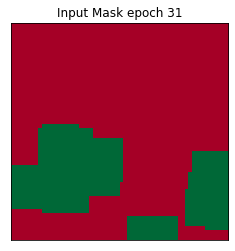

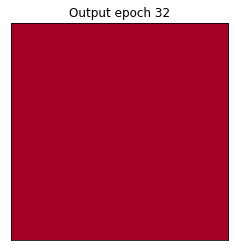

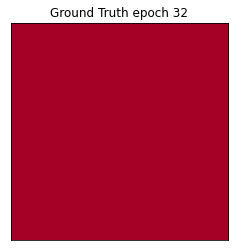

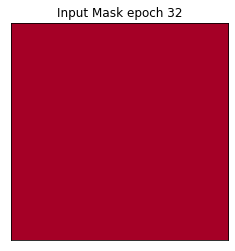

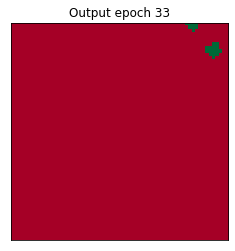

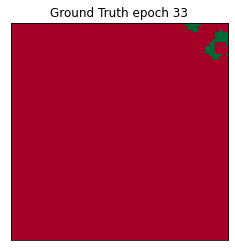

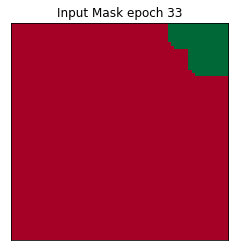

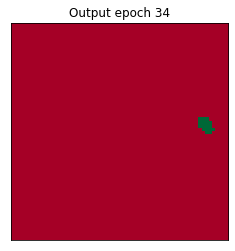

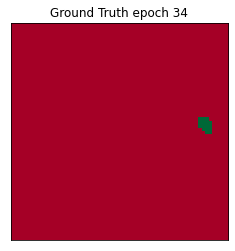

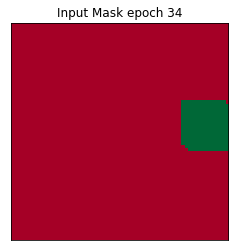

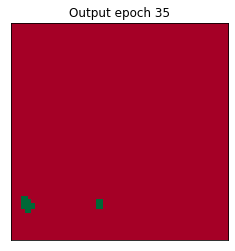

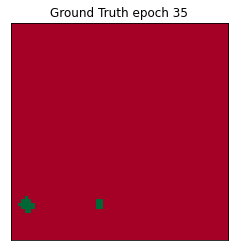

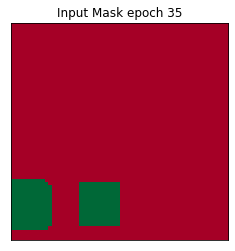

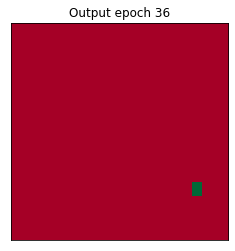

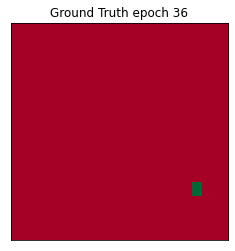

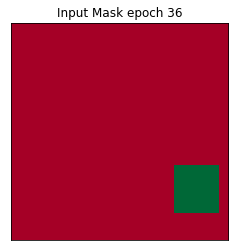

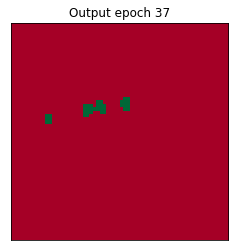

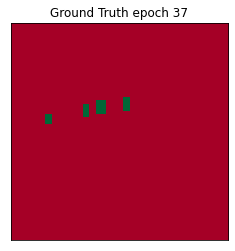

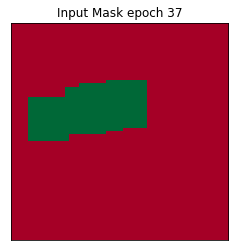

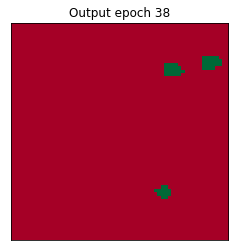

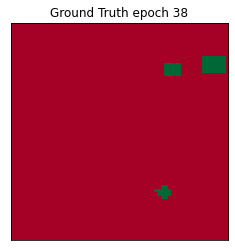

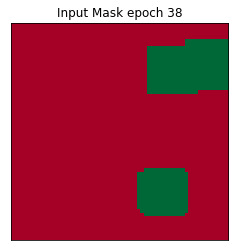

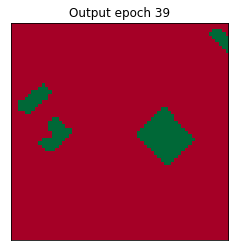

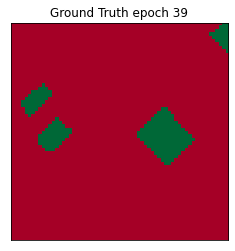

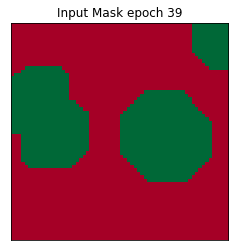

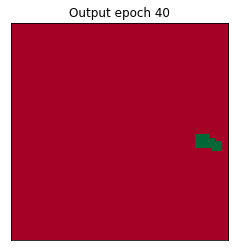

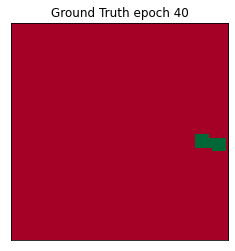

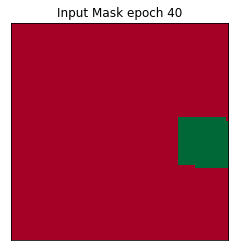

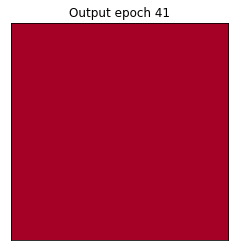

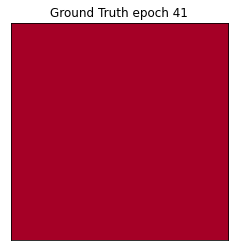

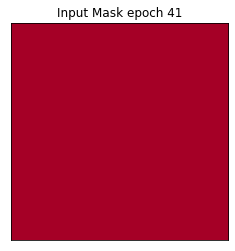

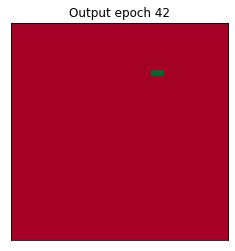

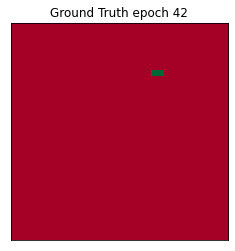

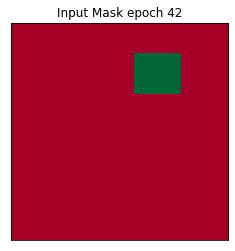

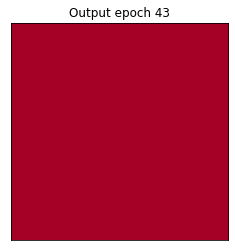

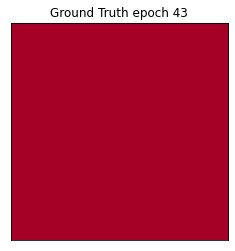

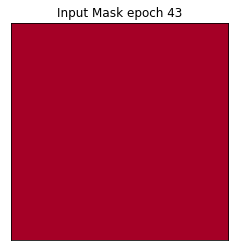

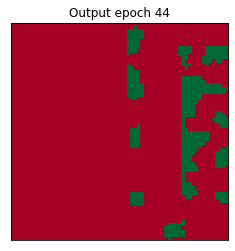

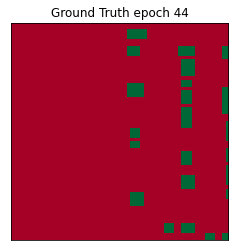

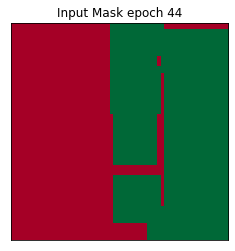

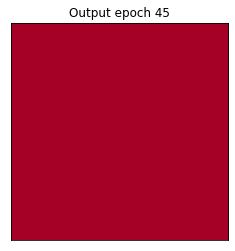

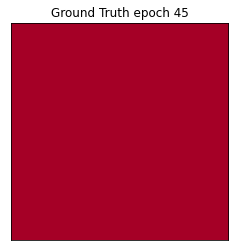

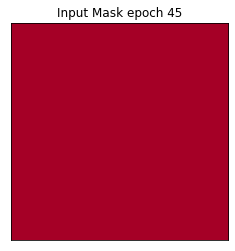

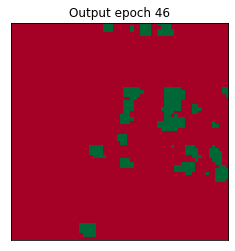

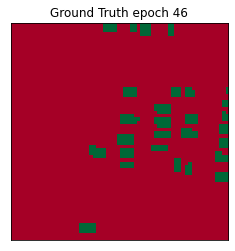

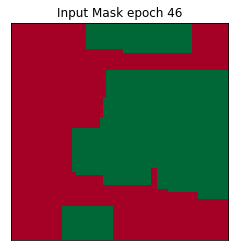

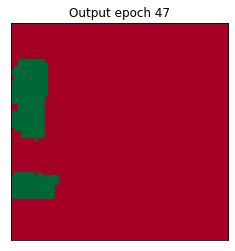

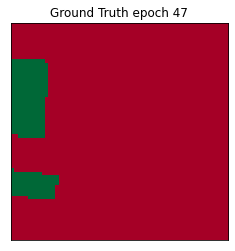

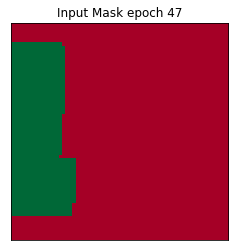

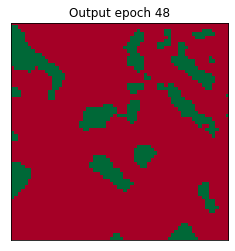

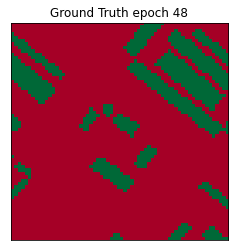

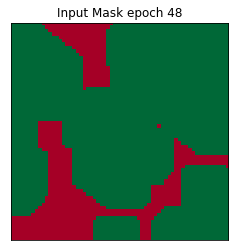

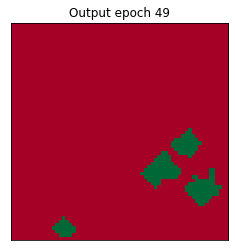

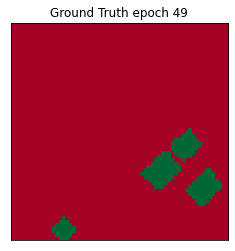

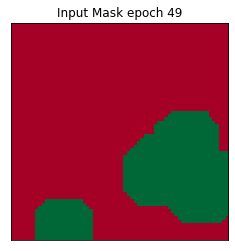

In [112]:
#print(example[0].shape)
ep = 0
for example in examples_basic:
    #print(example[0])
    print(ep)
    show_batch_images(example[0],1, f"Output epoch {ep}")
    show_batch_images(example[1],1, f"Ground Truth epoch {ep}")
    show_batch_images(example[2].type(torch.float32),1, f"Input Mask epoch {ep}")
    ep += 1